<a href="https://colab.research.google.com/github/fidanfatih/Fraud_Detection/blob/main/fraud_detection_phase3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder
import re
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")

%matplotlib inline

# pd.options.display.max_rows = 1000
# pd.options.display.max_columns = 1000
# pd.options.display.max_colwidth = 1000

## FUNCTIONS

#### Description Functions

In [26]:
df= pd.DataFrame()
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

In [27]:
!pip install colorama
def column_details(regex, df=df):
  # We will focus on each column in detail
  # Uniqe Values, DTYPE, NUNIQUE, NULL_RATE
  global columns
  columns=[col for col in df.columns if re.search(regex, col)]

  from colorama import Fore, Back, Style

  print('Unique Values of the Features:\nfeature: DTYPE, NUNIQUE, NULL_RATE\n')
  for i in df[columns]:
      color = Fore.RED if df[i].dtype =='float64' else Fore.BLUE if df[i].dtype =='int64' else Fore.GREEN
      print(f'{i}: {color} {df[i].dtype}, {df[i].nunique()}, %{round(df[i].isna().sum()/len(df[i])*100,2)}\n{Style.RESET_ALL}{pd.Series(df[i].unique()).sort_values().values}\n')
      

#### Plot Functions

In [28]:
def labels(ax, df=df, xytext=(0, 0)):
    for bar in ax.patches: 
        ax.annotate('%{:.2f}\n{:.0f}'.format(100*bar.get_height()/len(df),bar.get_height()), (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                    size=11, xytext=xytext, 
                    textcoords='offset points')

def plot_col(col, df=df, figsize=(20,6)):

    fig, ax = plt.subplots(1,2,figsize=figsize, sharey=True)

    plt.subplot(121)
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)

    ax[0] = sns.countplot(x=col, data=df, hue='isFraud', 
                  order=np.sort(df[col].dropna().unique()),
                  )
    ax[0].tick_params(axis='x', rotation=90)
    labels(ax[0],df[col].dropna(),(0, 0))
    
    ax_twin = ax[0].twinx()
    # sns.set(rc={"lines.linewidth": 0.7})
    ax_twin = sns.pointplot(x=col, y='Fraud', data=tmp, color='black', legend=False, 
                  order = np.sort(df[col].dropna().unique()), 
                  linewidth=0.1)
    

    ax[0].grid()

    plt.subplot(122)
    ax[1] = sns.countplot(x=df[col].dropna(),
                  order= np.sort(df[col].dropna().unique()),
                  )
    ax[1].tick_params(axis='x', rotation=90)
    labels(ax[1],df[col].dropna())
    plt.show()


In [29]:
def plot_cols(regex, figsize, target, df=df):
  columns=[col for col in df.columns if re.search(regex, col)]
  nrow, ncolumn = len(columns),1

  fig, ax = plt.subplots(nrow, ncolumn,figsize=figsize)

  for i,col in enumerate(columns):
      order = np.sort(df[col].dropna().unique())
      
      plt.subplot(nrow,ncolumn,i+1)
      ax[i] = sns.countplot(x=df[col], data= df, hue=target, order = order)
  #     labels(ax[i],df[col].dropna(),(0,0))
      
      tmp = pd.crosstab(df[col], df[target], normalize='index') * 100
      tmp = tmp.reset_index()
      tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
      
      ax_twin = ax[i].twinx()
  #     sns.set(rc={"lines.linewidth": 1})
      ax_twin = sns.pointplot(x=tmp[col], y=tmp['Fraud'],color='black', order = order)
      ax[i].grid();

In [30]:
def hist_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=df):
  plt.figure(figsize=figsize)
  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.histplot(x=df[col], data= df, hue=target)
      else:
          sns.countplot(x=df[col], data= df, hue=target) 

In [31]:
def box_countplot(regex, figsize, nrow=10, ncolumn = 4, target='isFraud', df=df):
  plt.figure(figsize=figsize)

  columns=[col for col in df.columns if re.search(regex, col)]

  for i,col in enumerate(columns):
      plt.subplot(nrow,ncolumn,i+1)
      if df[col].dtype!='O':
          sns.boxplot(y=df[col], data= df, x=target)
      else:
          sns.countplot(x=df[col])

In [32]:
def box_labels(ax, df, col1,col2):
    medians = df.groupby([col1])[col2].median().round(2)
    vertical_offset = df[col2].median() * 0.05 # offset from median for display

    for xtick in ax.get_xticks():
        ax.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
                horizontalalignment='center',size='small',color='w',weight='semibold')

#### Correlation Functions

In [33]:
# Remove the highly collinear features from data
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
#                 print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return drops

In [34]:
def corrank(X, threshold=0):
    import itertools
    df = pd.DataFrame([[i,j,X.corr().abs().loc[i,j]] for i,j in list(itertools.combinations(X.corr().abs(), 2))],columns=['Feature1','Feature2','corr'])    
    df = df.sort_values(by='corr',ascending=False).reset_index(drop=True)
    return df[df['corr']>threshold]

In [35]:
import scipy.stats as sts

# References:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
# https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

def cramers_v(x, y):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = sts.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

#### Outlier Functions

In [36]:
def outliers(s):
  # summary of the outliers
  iqr = (np.quantile(s, 0.75))-(np.quantile(s, 0.25))
  upper_bound = np.quantile(s, 0.75)+(1.5*iqr)
  lower_bound = np.quantile(s, 0.25)-(1.5*iqr)
  f = []
  for i in s:
      if i > upper_bound:
          f.append(i)
      elif i < lower_bound:
          f.append(i)
  sums = len(f)
  pros = len(f)/len(s)*100
  d = {'IQR':iqr,
        'Upper Bound':upper_bound,
      'Lower Bound':lower_bound,
      'Sum outliers': sums,'percentage outliers':pros}
  d = pd.DataFrame(d.items(),columns = ['sub','values'])
  return(d)


In [37]:
def capping_outliers(col, whisker=1.5):
  # replace outliers with upper_bound and lower_bound values

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)

  df[col] = np.where(df[col] < upper_bound, 
                                upper_bound,df[col])
  df[col] = np.where(df[col] > lower_bound, 
                                lower_bound,df[col])
  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);
  return df[col]

In [38]:
def replace_outliers(col, replaced_value='median',whisker=1.5):
  # replace outliers with 'median','mean','mode' or an assigned value.

  iqr = (np.quantile(df[col], 0.75))-(np.quantile(df[col], 0.25))
  upper_bound = np.quantile(df[col], 0.75)+(whisker*iqr)
  lower_bound = np.quantile(df[col], 0.25)-(whisker*iqr)
  if replaced_value=='median':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].median())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].median())
  elif replaced_value=='mean':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mean())
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mean())
  elif replaced_value=='mode':
    df[col] = df[col].mask(df[col] > upper_bound, df[col].mode()[0])
    df[col] = df[col].mask(df[col] < lower_bound, df[col].mode()[0])
  else:
    df[col] = df[col].mask(df[col] > upper_bound, replaced_value)
    df[col] = df[col].mask(df[col] < lower_bound, replaced_value)   

  plt.figure(figsize=(12,6))
  sns.boxplot(x= df[col]);

  return df[col]

In [39]:
def col_plot(df,col_name):
    plt.figure(figsize=(15,6))
    
    plt.subplot(141) # 1 satir x 4 sutun dan olusan ax in 1. sutununda calis
    plt.hist(df[col_name], bins = 20)
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    
    # üç sigma aralikta(verinin %99.7 sini icine almasi beklenen bolum) iki kirmizi cizgi arasinda
    plt.axvline(x=df[col_name].mean() + 3*df[col_name].std(),color='red')
    plt.axvline(x=df[col_name].mean() - 3*df[col_name].std(),color='red')
    plt.xlabel(col_name)
    plt.tight_layout
    plt.xlabel("Histogram ±3z")
    plt.ylabel(col_name)

    plt.subplot(142)
    plt.boxplot(df[col_name]) # IQR katsayisi, defaultu 1.5
    plt.xlabel("IQR=1.5")

    plt.subplot(143)
    plt.boxplot(df[col_name].apply(f_sqrt), whis = 1.5)
    plt.xlabel("ROOT SQUARE - IQR=1.5")

    plt.subplot(144)
    plt.boxplot(df[col_name].apply(f_log), whis = 1.5)
    plt.xlabel("LOGARITMIC - IQR=1.5")
    plt.show()

In [40]:
def plot_winsorize(df,col_name,down=0, up=0.1):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
    root_winsor=winsorize(df[col_name].apply(f_sqrt), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(root_winsor, bins=22)
    plt.axvline(x=root_winsor.mean()+3*root_winsor.std(),color='red')
    plt.axvline(x=root_winsor.mean()-3*root_winsor.std(),color='red')
    plt.xlabel('root_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(root_winsor, whis = 1.5)
    plt.xlabel("Root & Winsorize - IQR=1.5")
    plt.show() 

In [41]:
def plot_log_winsorize(df,col_name,up=0.1,down=0):
    plt.figure(figsize = (15, 6))

    winsor=winsorize(df[col_name], (down,up))
    f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
    log_winsor=winsorize(df[col_name].apply(f_log), (down,up))

    plt.subplot(141)
    plt.hist(winsor, bins = 22)
    plt.axvline(x=winsor.mean()+3*winsor.std(),color='red')
    plt.axvline(x=winsor.mean()-3*winsor.std(),color='red')
    plt.xlabel('Winsorize_Histogram')
    plt.ylabel(col_name)
    plt.tight_layout

    plt.subplot(142)
    plt.boxplot(winsor, whis = 1.5)
    plt.xlabel('Winsorize - IQR:1.5')
    
    plt.subplot(143)
    plt.hist(log_winsor, bins=22)
    plt.axvline(x=log_winsor.mean()+3*log_winsor.std(),color='red')
    plt.axvline(x=log_winsor.mean()-3*log_winsor.std(),color='red')
    plt.xlabel('log_winsor_col_name')

    plt.subplot(144)
    plt.boxplot(log_winsor, whis = 1.5)
    plt.xlabel("Log & Winsorize - IQR=1.5")
    plt.show()

In [42]:
def simplify_column(col, df=df, threshold=0.005, value='mode'):
  df[col] = df[col].replace(df[col].value_counts(dropna=True)[df[col].value_counts(dropna=True, normalize=True)<threshold].index,df[col].mode()[0] if value=='mode' else 'other')
  return df[col]

### Memory Reduction Functions

In [43]:
# safe downcast
def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col

def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    if verbose:
        print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

### Label Encoder

In [44]:
# from sklearn.preprocessing import LabelEncoder
def label_encoder(cat_cols, df=df):
  for col in cat_cols:
      if col in df.columns:
          le = LabelEncoder()
          le.fit(list(df[col].astype(str).values))
          df[col] = le.transform(list(df[col].astype(str).values))
  return df

### Modeling

In [45]:
def plot_feature_importances(model, num=10, figsize=(20,10)):
    feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:num]
    plt.figure(figsize=figsize)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.title("Feature Importance")
    plt.show()

## Exploratory Data Analysis (EDA)

### Extract a 25k sample

In [49]:
# from google.colab import drive
# drive.mount('/content/drive')

In [50]:
# data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/train_reduced.csv',index_col=[0])
data = data.sort_values('TransactionDT').reset_index().drop('index', axis=1)
df= data.copy()
df = reduce_mem_usage_sd(df, verbose=True)
df.head()

Column TransactionID: int64 -> int32, na_count=0, n_uniq=590540
Column isFraud: int64 -> int8, na_count=0, n_uniq=2
Column TransactionDT: int64 -> int32, na_count=0, n_uniq=573349
Column TransactionAmt: float64 -> float32, na_count=0, n_uniq=20902
Column ProductCD: object -> object, na_count=0, n_uniq=5
Column card1: int64 -> int16, na_count=0, n_uniq=13553
Column card2: float64 -> float16, na_count=8933, n_uniq=501
Column card3: float64 -> float16, na_count=1565, n_uniq=115
Column card4: object -> object, na_count=1577, n_uniq=5
Column card5: float64 -> float16, na_count=4259, n_uniq=120
Column card6: object -> object, na_count=1571, n_uniq=5
Column addr1: float64 -> float16, na_count=65706, n_uniq=333
Column addr2: float64 -> float16, na_count=65706, n_uniq=75
Column dist1: float64 -> float32, na_count=352271, n_uniq=2652
Column dist2: float64 -> float32, na_count=552913, n_uniq=1752
Column P_emaildomain: object -> object, na_count=94456, n_uniq=60
Column R_emaildomain: object -> obj

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Transaction_hour,Transaction_day_of_week
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1,1,0,0,0,1,0,0,1,0,2,0,1,1,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1,1,0,0,0,1,0,0,0,0,1,0,1,1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1,1,0,0,0,1,0,0,1,0,1,0,1,1,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2,5,0,0,0,4,0,0,1,0,1,0,25,1,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1,1,0,0,0,1,0,1,0,1,1,0,1,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,0,0


### Summarize data

In [51]:
df.describe(include="all").T.sort_values("unique")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
M7,244275,2,F,211374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DeviceType,140810,2,desktop,85165,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id_12,144233,2,NotFound,123025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M9,244288,2,T,205656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
M8,244288,2,F,155251,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
id_25,5132,NaN,NaN,NaN,inf,97.4375,100,321,321,371,548
id_26,5163,NaN,NaN,NaN,inf,32.0938,100,119,149,169,216
id_32,77586,NaN,NaN,NaN,NaN,0,0,24,24,32,32
Transaction_hour,590540,NaN,NaN,NaN,13.8619,7.60715,0,6,16,20,23


In [52]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

# display(summary(df).sort_values(by='Uniques', ascending=True))

### Handling missing values

In [53]:
missig_rate = np.product(df.isnull().sum().sum())/ np.product(df.shape)*100
print(f'% of missing data: {missig_rate:.2f}')

% of missing data: 44.87


In [54]:
# import missingno as msno
# msno.matrix(df.sample(100));

In [55]:
def null_values(df, rate=0):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv['Percentage (%)']>rate].sort_values('Percentage (%)', ascending=False)
null_values(df, 90)

,Missing_Records,Percentage (%)
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
id_26,585377,99.125715
id_22,585371,99.124699
id_23,585371,99.124699
id_27,585371,99.124699
dist2,552913,93.628374


In [56]:
# Columns having Null values more than 90%  
many_null_cols = null_values(df, 90).index
print(many_null_cols)

Index(['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_22', 'id_23',
       'id_27', 'dist2', 'D7', 'id_18'],
      dtype='object')


In [57]:
# Columns having a single value of more than %90 including missing values
big_top_value_cols_1 = [col for col in df.columns if df[col].value_counts(dropna=False, normalize=True).values[0] > 0.90]
print(big_top_value_cols_1)

['isFraud', 'dist2', 'C3', 'D7', 'V98', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [58]:
# Columns having a single value of more than %97.5 except missing values
big_top_value_cols_2 = [col for col in df.columns if df[col].value_counts(dropna=True, normalize=True).values[0] > 0.975]
print(big_top_value_cols_2)

['addr2', 'C3', 'M1', 'V1', 'V14', 'V27', 'V28', 'V41', 'V46', 'V65', 'V68', 'V88', 'V89', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V138', 'V191', 'V193', 'V196', 'V240', 'V241', 'V247', 'V249', 'V252', 'V269', 'V305', 'id_04', 'id_27']


In [59]:
# Columns having one unique value
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
one_value_cols

[]

### Feature Engineering (TransactionDT)

In [60]:
df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)

### Drop redundant columns

In [61]:
cols_to_drop = set(list(many_null_cols)+ big_top_value_cols_1 + big_top_value_cols_2 + one_value_cols)
cols_to_drop.remove('isFraud')
len(cols_to_drop)

89

In [62]:
print(sorted(cols_to_drop))

['C3', 'D7', 'M1', 'V1', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V129', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V14', 'V191', 'V193', 'V196', 'V240', 'V241', 'V247', 'V249', 'V252', 'V269', 'V27', 'V28', 'V281', 'V284', 'V286', 'V290', 'V293', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 'V301', 'V305', 'V309', 'V311', 'V316', 'V318', 'V319', 'V320', 'V321', 'V41', 'V46', 'V65', 'V68', 'V88', 'V89', 'V98', 'addr2', 'dist2', 'id_04', 'id_07', 'id_08', 'id_18', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27']


In [63]:
df = df.drop(cols_to_drop, axis=1)

In [64]:
print(list(df.columns))

['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V42', 'V43', 'V44', 'V45', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V66', 'V67', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V

In [65]:
df = df.drop('TransactionID', axis=1)

    **FEATURES**
- **`isFraud` : binary, Target**
- `TransactionID` : all unique 
- `TransactionDT` : time series
- `TransactionAmt` : continous, full
- `P_emaildomain` : categoric, 56 uniques
- `R_emaildomain` : categoric, 59 uniques
- `DeviceType` : categoric, 2 uniques
- `DeviceInfo` : categoric, 700 uniques
- `ProductCD` : categoric, 5 uniques
- `card1-6` : categoric 2, numeric 4  Abuzer
- `dist1-2` : numeric 2 Abuzer
- `C1-14` : numeric Abuzer
- `D1-15` : numeric Emrah
- `M1-9` : categoric Emrah
- `V1-339` : numeric, categoric
- `id_01_38` : numeric, categoric

### id_01-38

In [66]:
columns=[]
column_details(regex='id_\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_01:  float16, 77, %75.58
[-100.  -99.  -96.  -95.  -94.  -93.  -92.  -90.  -89.  -88.  -87.  -86.
  -85.  -82.  -80.  -76.  -75.  -72.  -71.  -70.  -65.  -64.  -63.  -62.
  -61.  -60.  -58.  -57.  -56.  -55.  -54.  -53.  -52.  -51.  -50.  -48.
  -47.  -46.  -45.  -44.  -43.  -42.  -40.  -38.  -37.  -35.  -34.  -33.
  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.  -22.  -21.
  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.  -10.   -9.
   -8.   -7.   -6.   -5.    0.   nan]

id_02:  float32, 115655, %76.15
[1.00000e+00 2.00000e+00 3.00000e+01 ... 9.99074e+05 9.99595e+05
         nan]

id_03:  float16, 24, %88.77
[-13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.
   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  nan]

id_05:  float16, 93, %76.82
[-72. -46. -44. -40. -39. -38. -37. -35. -34. -33. -32. -31. -30. -29.
 -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17.

#### id_30

In [67]:
# grouping and converting data to the same standard
df.id_30.value_counts().sort_index().index

Index(['Android', 'Android 4.4.2', 'Android 5.0', 'Android 5.0.2',
       'Android 5.1.1', 'Android 6.0', 'Android 6.0.1', 'Android 7.0',
       'Android 7.1.1', 'Android 7.1.2', 'Android 8.0.0', 'Android 8.1.0',
       'Linux', 'Mac', 'Mac OS X 10.10', 'Mac OS X 10.11', 'Mac OS X 10.12',
       'Mac OS X 10.13', 'Mac OS X 10.6', 'Mac OS X 10.9', 'Mac OS X 10_10_5',
       'Mac OS X 10_11_3', 'Mac OS X 10_11_4', 'Mac OS X 10_11_5',
       'Mac OS X 10_11_6', 'Mac OS X 10_12', 'Mac OS X 10_12_1',
       'Mac OS X 10_12_2', 'Mac OS X 10_12_3', 'Mac OS X 10_12_4',
       'Mac OS X 10_12_5', 'Mac OS X 10_12_6', 'Mac OS X 10_13_1',
       'Mac OS X 10_13_2', 'Mac OS X 10_13_3', 'Mac OS X 10_13_4',
       'Mac OS X 10_13_5', 'Mac OS X 10_6_8', 'Mac OS X 10_7_5',
       'Mac OS X 10_8_5', 'Mac OS X 10_9_5', 'Windows', 'Windows 10',
       'Windows 7', 'Windows 8', 'Windows 8.1', 'Windows Vista', 'Windows XP',
       'func', 'iOS', 'iOS 10.0.2', 'iOS 10.1.1', 'iOS 10.2.0', 'iOS 10.2.1',
      

In [68]:
df.id_30.replace(regex={r'^Android.*': 'android', 
                        '^Mac.*': 'mac',
                        '^Windows.*': 'windows', 
                        '^iOS.*': 'ios',
                        '^Linux.*': 'linux'}, inplace=True)

df.id_30.value_counts(dropna=False)

NaN        512975
windows     36739
ios         19782
mac         13580
android      6303
linux        1136
other          15
func           10
Name: id_30, dtype: int64

#### id_31

In [69]:
# grouping and converting data to the same standard
list(df.id_31.value_counts().sort_index().index)

['BLU/Dash',
 'Cherry',
 'Generic/Android',
 'Generic/Android 7.0',
 'Inco/Minion',
 'LG/K-200',
 'Lanix/Ilium',
 'M4Tel/M4',
 'Microsoft/Windows',
 'Mozilla/Firefox',
 'Nokia/Lumia',
 'Samsung/SCH',
 'Samsung/SM-G531H',
 'Samsung/SM-G532M',
 'ZTE/Blade',
 'android',
 'android browser 4.0',
 'android webview 4.0',
 'aol',
 'chrome',
 'chrome 43.0 for android',
 'chrome 46.0 for android',
 'chrome 49.0',
 'chrome 49.0 for android',
 'chrome 50.0 for android',
 'chrome 51.0',
 'chrome 51.0 for android',
 'chrome 52.0 for android',
 'chrome 53.0 for android',
 'chrome 54.0 for android',
 'chrome 55.0',
 'chrome 55.0 for android',
 'chrome 56.0',
 'chrome 56.0 for android',
 'chrome 57.0',
 'chrome 57.0 for android',
 'chrome 58.0',
 'chrome 58.0 for android',
 'chrome 59.0',
 'chrome 59.0 for android',
 'chrome 60.0',
 'chrome 60.0 for android',
 'chrome 61.0',
 'chrome 61.0 for android',
 'chrome 62.0',
 'chrome 62.0 for android',
 'chrome 62.0 for ios',
 'chrome 63.0',
 'chrome 63.0 for

In [70]:
df.id_31 = data.id_31.copy()
df.id_31.replace(regex={r'samsung.*': 'samsung_browser',
                        '^Samsung.*': 'samsung_browser',
                        '.*safari.*': 'safari',
                        'opera.*': 'opera', 
                        '^ie.*': 'ie',
                        'firefox.*': 'firefox',
                        '^Mozilla.*':'firefox',
                        'edge.*': 'edge', 
                        '^chrome.*': 'chrome',
                        '^google.*': 'chrome',
                        'android.*': 'android',
                        'Generic.*': 'android',
                        'Android':"android", 
                        'firefox.*': 'firefox',
                        'edge.*': 'edge', 
                        'Microsoft.*':'ie'}, inplace=True)

df.id_31.value_counts(dropna=False, normalize=True)


NaN                0.762451
chrome             0.129043
safari             0.063130
ie                 0.016524
firefox            0.011882
edge               0.010839
samsung_browser    0.003805
android            0.000887
opera              0.000760
other              0.000528
silk               0.000032
mobile             0.000019
ZTE/Blade          0.000015
line               0.000010
maxthon            0.000010
comodo             0.000010
aol                0.000008
icedragon          0.000008
Lanix/Ilium        0.000005
puffin             0.000003
palemoon           0.000003
facebook           0.000003
waterfox           0.000003
Cherry             0.000002
Nokia/Lumia        0.000002
seamonkey          0.000002
cyberfox           0.000002
LG/K-200           0.000002
chromium           0.000002
iron               0.000002
M4Tel/M4           0.000002
Inco/Minion        0.000002
BLU/Dash           0.000002
Name: id_31, dtype: float64

#### id_33

In [71]:
# dtype transformation and discretization
df.id_33.value_counts(dropna=False).head(5)

NaN          517251
1920x1080     16874
1366x768       8605
1334x750       6447
2208x1242      4900
Name: id_33, dtype: int64

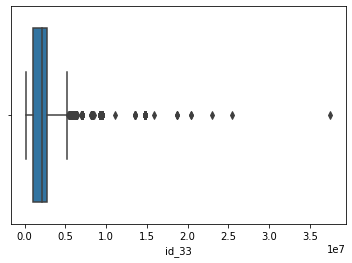

In [72]:
df.id_33 = df.id_33.fillna(value='0x0').str.extract('(\d*)x(\d*)').apply(lambda x: int(x[0])*int(x[1]), axis=1)
df.id_33 = df.id_33.replace({0:np.nan})
sns.boxplot(df.id_33);

In [73]:
df.id_33.value_counts().sort_index().index

Float64Index([  153600.0,   230400.0,   270000.0,   384480.0,   410400.0,
                442368.0,   480000.0,   518400.0,   565248.0,   585600.0,
              ...
              11025000.0, 13492501.0, 13500000.0, 14745600.0, 15876000.0,
              18662400.0, 20358144.0, 23040000.0, 25401600.0, 37500000.0],
             dtype='float64', length=256)

#### Multicollinearity

In [74]:
column_details(regex='id_\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

id_01:  float16, 77, %75.58
[-100.  -99.  -96.  -95.  -94.  -93.  -92.  -90.  -89.  -88.  -87.  -86.
  -85.  -82.  -80.  -76.  -75.  -72.  -71.  -70.  -65.  -64.  -63.  -62.
  -61.  -60.  -58.  -57.  -56.  -55.  -54.  -53.  -52.  -51.  -50.  -48.
  -47.  -46.  -45.  -44.  -43.  -42.  -40.  -38.  -37.  -35.  -34.  -33.
  -32.  -31.  -30.  -29.  -28.  -27.  -26.  -25.  -24.  -23.  -22.  -21.
  -20.  -19.  -18.  -17.  -16.  -15.  -14.  -13.  -12.  -11.  -10.   -9.
   -8.   -7.   -6.   -5.    0.   nan]

id_02:  float32, 115655, %76.15
[1.00000e+00 2.00000e+00 3.00000e+01 ... 9.99074e+05 9.99595e+05
         nan]

id_03:  float16, 24, %88.77
[-13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.
   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  nan]

id_05:  float16, 93, %76.82
[-72. -46. -44. -40. -39. -38. -37. -35. -34. -33. -32. -31. -30. -29.
 -28. -27. -26. -25. -24. -23. -22. -21. -20. -19. -18. -17.

In [75]:
# missing value correlation
# msno.heatmap(df[columns], figsize=(15, 8), fontsize=10);

In [76]:
# # Feature correlations
# plt.figure(figsize=(15,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [77]:
# corrank(df[columns], 0.8)

In [78]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

set()

In [79]:
cat_columns=['id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
pd.Series([cramers_v(df.id_28,df[col]) for col in cat_columns], index=cat_columns).sort_values(ascending=False)
# cramers_v(df.id_28,df.id_16)

id_28    0.999986
id_29    0.981504
id_15    0.885954
id_16    0.876095
id_33    0.380034
id_30    0.377529
id_37    0.350657
id_32    0.348569
id_34    0.343891
id_31    0.327273
id_12    0.297254
id_35    0.082093
id_36    0.073097
id_38    0.072889
dtype: float64

> Multicolliniarity treshold is  having upper than 0.8

In [80]:
drop_col=['id_15','id_16','id_29']
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [81]:
columns=[col for col in df.columns if re.search('^id', col)]
print(columns)

['id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_28', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


In [82]:
# outliers(df.id_01.dropna())

In [83]:
# for col in columns[:8]:
#   col_plot(df[col].dropna().to_frame(),col)

In [84]:
# for col in columns[:8]:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [85]:
# for col in columns[:8]:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [86]:
# df['id_11'] = data['id_11'].copy()
# df['id_11'].value_counts()

In [87]:
# df['id_01'] = data['id_01'].copy()
# df['id_01']= df.id_01.apply(lambda x: 1 if x!=-5 else 0)
# # df['id_02'] = pd.Series( winsorize(df.id_02, limits=(0, 0.1)))
# df['id_02'] = df.id_02**0.35
# df['id_03']= df.id_03.apply(lambda x: 1 if x!=0 else x)
# df['id_05']= df.id_05.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
# df['id_06']= df.id_06.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
# df['id_09']= df.id_09.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
# df['id_10']= df.id_09.apply(lambda x: 1 if x>0 else -1 if x<0 else 0)
# df['id_11'] = df.id_11.apply(lambda x: 0 if x<100 else 1)

#### Reduction of diversity in categorical columns

In [88]:
# for col in set(columns)-set(['id_02']):
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')

#### Plots

In [89]:
# for col in np.sort(list(set(columns)-set(['id_02']))):
#   plot_col(col, df=df, figsize=(20,5))

In [90]:
# plot_cols(regex='id_\d*', figsize=(10, 25), target='isFraud', df=df)

In [91]:
# hist_countplot(regex='id_\d*', figsize=(30, 60), nrow=10, ncolumn = 4, df=df)

In [92]:
# box_countplot(regex='id_\d*', figsize=(30, 60), nrow=10, ncolumn = 4, df=df)

#### Label Encoders

In [93]:
# cat_cols= np.sort(list(set(columns)-set(['id_02'])))
cat_cols= ['id_12', 'id_13', 'id_14', 'id_17', 'id_19', 'id_20', 'id_28', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']
df= label_encoder(cat_cols=cat_cols, df=df)

In [94]:
# for col in np.sort(list(set(columns)-set(['id_02']))):
#   plot_col(col, df=df, figsize=(20,5))

### V1-339

#### Multicolliniarity

In [95]:
column_details(regex='V\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

V2:  float16, 9, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V3:  float16, 10, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V4:  float16, 7, %47.29
[ 0.  1.  2.  3.  4.  5.  6. nan]

V5:  float16, 7, %47.29
[ 0.  1.  2.  3.  4.  5.  6. nan]

V6:  float16, 10, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V7:  float16, 10, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V8:  float16, 9, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V9:  float16, 9, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V10:  float16, 5, %47.29
[ 0.  1.  2.  3.  4. nan]

V11:  float16, 6, %47.29
[ 0.  1.  2.  3.  4.  5. nan]

V12:  float16, 4, %12.88
[ 0.  1.  2.  3. nan]

V13:  float16, 7, %12.88
[ 0.  1.  2.  3.  4.  5.  6. nan]

V15:  float16, 8, %12.88
[ 0.  1.  2.  3.  4.  5.  6.  7. nan]

V16:  float16, 15, %12.88
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 13. 14. 15. nan]

V17:  float16, 16, %12.88

In [96]:
len(columns)

266

**V Features Groups according to the missing value correlation**

* V2-11
* V12-34
* V35-52
* V53-74
* V75-94
* V95-131
* V139-166
* V167-216
* V217-278
* V279-317
* V322-339

##### V2-11

In [97]:
columns = [f'V{i}' for i in range(2,12) if f'V{i}' in columns ]
columns

['V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11']

In [98]:
# msno.heatmap(df[columns], figsize=(10, 5), fontsize=10);

In [99]:
# plt.figure(figsize=(10,7))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [100]:
# corrank(df[columns], 0.8)

In [101]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V11', 'V5', 'V9'}

In [102]:
df = df.drop(drop_col, axis=1)

##### V12-34

In [103]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(12,35) if f'V{i}' in columns ]
columns

['V12',
 'V13',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34']

In [104]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [105]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [106]:
# corrank(df[columns], 0.8)

In [107]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V13',
 'V16',
 'V17',
 'V18',
 'V20',
 'V21',
 'V22',
 'V24',
 'V26',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34'}

In [108]:
df = df.drop(drop_col, axis=1)

##### V35-52

In [109]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(35,53) if f'V{i}' in columns ]
columns

['V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V42',
 'V43',
 'V44',
 'V45',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52']

In [110]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [111]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [112]:
# corrank(df[columns], 0.8)

In [113]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V36', 'V38', 'V40', 'V42', 'V43', 'V45', 'V49', 'V50', 'V51', 'V52'}

In [114]:
df = df.drop(drop_col, axis=1)

##### V53-74

In [115]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(53,75) if f'V{i}' in columns ]
columns

['V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V66',
 'V67',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74']

In [116]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [117]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [118]:
# corrank(df[columns], 0.8)

In [119]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V54',
 'V58',
 'V59',
 'V60',
 'V62',
 'V63',
 'V64',
 'V67',
 'V70',
 'V71',
 'V72',
 'V73',
 'V74'}

In [120]:
df = df.drop(drop_col, axis=1)

##### V75-94

In [121]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(75,95) if f'V{i}' in columns ]
columns

['V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V84',
 'V85',
 'V86',
 'V87',
 'V90',
 'V91',
 'V92',
 'V93',
 'V94']

In [122]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [123]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [124]:
# corrank(df[columns], 0.8)

In [125]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V76', 'V81', 'V83', 'V84', 'V85', 'V87', 'V91', 'V92', 'V93', 'V94'}

In [126]:
df = df.drop(drop_col, axis=1)

##### V95-131

In [127]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(95,132) if f'V{i}' in columns ]
columns

['V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131']

In [128]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [129]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [130]:
# corrank(df[columns], 0.8)

In [131]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V100', 'V126', 'V127', 'V128', 'V96', 'V97'}

In [132]:
df = df.drop(drop_col, axis=1)

##### V132-166

In [133]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(132,167) if f'V{i}' in columns ]
columns

['V139',
 'V140',
 'V141',
 'V142',
 'V143',
 'V144',
 'V145',
 'V146',
 'V147',
 'V148',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V161',
 'V162',
 'V163',
 'V164',
 'V165',
 'V166']

In [134]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [135]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [136]:
# corrank(df[columns], 0.8)

In [137]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V140',
 'V142',
 'V145',
 'V147',
 'V149',
 'V150',
 'V151',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V159',
 'V160',
 'V162',
 'V163',
 'V164',
 'V165'}

In [138]:
df = df.drop(drop_col, axis=1)

##### V167-216

In [139]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(167,217) if f'V{i}' in columns ]
columns

['V167',
 'V168',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V177',
 'V178',
 'V179',
 'V180',
 'V181',
 'V182',
 'V183',
 'V184',
 'V185',
 'V186',
 'V187',
 'V188',
 'V189',
 'V190',
 'V192',
 'V194',
 'V195',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V205',
 'V206',
 'V207',
 'V208',
 'V209',
 'V210',
 'V211',
 'V212',
 'V213',
 'V214',
 'V215',
 'V216']

In [140]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [141]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [142]:
# corrank(df[columns], 0.8)

In [143]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V168',
 'V177',
 'V178',
 'V179',
 'V180',
 'V182',
 'V183',
 'V185',
 'V186',
 'V189',
 'V190',
 'V192',
 'V195',
 'V197',
 'V198',
 'V199',
 'V200',
 'V201',
 'V202',
 'V203',
 'V204',
 'V207',
 'V211',
 'V212',
 'V213',
 'V216'}

In [144]:
df = df.drop(drop_col, axis=1)

##### V217-278

In [145]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(217,279) if f'V{i}' in columns ]
columns

['V217',
 'V218',
 'V219',
 'V220',
 'V221',
 'V222',
 'V223',
 'V224',
 'V225',
 'V226',
 'V227',
 'V228',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V242',
 'V243',
 'V244',
 'V245',
 'V246',
 'V248',
 'V250',
 'V251',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V260',
 'V261',
 'V262',
 'V263',
 'V264',
 'V265',
 'V266',
 'V267',
 'V268',
 'V270',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V276',
 'V277',
 'V278']

In [146]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [147]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [148]:
# corrank(df[columns], 0.8)

In [149]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V218',
 'V219',
 'V222',
 'V225',
 'V229',
 'V230',
 'V231',
 'V232',
 'V233',
 'V234',
 'V236',
 'V237',
 'V239',
 'V243',
 'V244',
 'V245',
 'V246',
 'V248',
 'V251',
 'V253',
 'V254',
 'V255',
 'V256',
 'V257',
 'V258',
 'V259',
 'V261',
 'V262',
 'V265',
 'V267',
 'V268',
 'V271',
 'V272',
 'V273',
 'V274',
 'V275',
 'V277',
 'V278'}

In [150]:
df = df.drop(drop_col, axis=1)

##### V279-317

In [151]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(279,318) if f'V{i}' in columns ]
columns

['V279',
 'V280',
 'V282',
 'V283',
 'V285',
 'V287',
 'V288',
 'V289',
 'V291',
 'V292',
 'V294',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V310',
 'V312',
 'V313',
 'V314',
 'V315',
 'V317']

In [152]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [153]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [154]:
# corrank(df[columns], 0.8)

In [155]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V280',
 'V287',
 'V289',
 'V292',
 'V294',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V315',
 'V317'}

In [156]:
df = df.drop(drop_col, axis=1)

##### V318-339

In [157]:
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(318,340) if f'V{i}' in columns ]
columns

['V322',
 'V323',
 'V324',
 'V325',
 'V326',
 'V327',
 'V328',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V334',
 'V335',
 'V336',
 'V337',
 'V338',
 'V339']

In [158]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [159]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [160]:
# corrank(df[columns], 0.8)

In [161]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V323',
 'V324',
 'V327',
 'V329',
 'V330',
 'V331',
 'V332',
 'V333',
 'V336',
 'V338',
 'V339'}

In [162]:
df = df.drop(drop_col, axis=1)

##### Last Review

In [163]:
# Multicolliniarity of all V columns
columns=[col for col in df.columns if re.search('V\d*', col)]
columns = [f'V{i}' for i in range(1,340) if f'V{i}' in columns ]
columns

['V2',
 'V3',
 'V4',
 'V6',
 'V7',
 'V8',
 'V10',
 'V12',
 'V15',
 'V19',
 'V23',
 'V25',
 'V29',
 'V35',
 'V37',
 'V39',
 'V44',
 'V47',
 'V48',
 'V53',
 'V55',
 'V56',
 'V57',
 'V61',
 'V66',
 'V69',
 'V75',
 'V77',
 'V78',
 'V79',
 'V80',
 'V82',
 'V86',
 'V90',
 'V95',
 'V99',
 'V130',
 'V131',
 'V139',
 'V141',
 'V143',
 'V144',
 'V146',
 'V148',
 'V161',
 'V166',
 'V167',
 'V169',
 'V170',
 'V171',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V181',
 'V184',
 'V187',
 'V188',
 'V194',
 'V205',
 'V206',
 'V208',
 'V209',
 'V210',
 'V214',
 'V215',
 'V217',
 'V220',
 'V221',
 'V223',
 'V224',
 'V226',
 'V227',
 'V228',
 'V235',
 'V238',
 'V242',
 'V250',
 'V260',
 'V263',
 'V264',
 'V266',
 'V270',
 'V276',
 'V279',
 'V282',
 'V283',
 'V285',
 'V288',
 'V291',
 'V302',
 'V310',
 'V312',
 'V313',
 'V314',
 'V322',
 'V325',
 'V326',
 'V328',
 'V334',
 'V335',
 'V337']

In [164]:
# msno.heatmap(df[columns], figsize=(15, 7), fontsize=10);

In [165]:
# plt.figure(figsize=(25,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=False, cmap="coolwarm");

In [166]:
# corrank(df[columns], 0.8)

In [167]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'V143',
 'V167',
 'V206',
 'V217',
 'V228',
 'V235',
 'V266',
 'V276',
 'V279',
 'V285',
 'V29',
 'V302',
 'V310',
 'V312',
 'V322',
 'V326',
 'V328',
 'V334',
 'V335',
 'V337',
 'V48',
 'V57',
 'V69',
 'V79',
 'V80',
 'V90'}

In [168]:
df = df.drop(drop_col, axis=1)

In [169]:
V_columns = [col for col in df.columns if re.search('V\d*', col)]
print(f"Current V Columns ({len(V_columns)}):\n\n{V_columns}")

Current V Columns (77):

['V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V10', 'V12', 'V15', 'V19', 'V23', 'V25', 'V35', 'V37', 'V39', 'V44', 'V47', 'V53', 'V55', 'V56', 'V61', 'V66', 'V75', 'V77', 'V78', 'V82', 'V86', 'V95', 'V99', 'V130', 'V131', 'V139', 'V141', 'V144', 'V146', 'V148', 'V161', 'V166', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V181', 'V184', 'V187', 'V188', 'V194', 'V205', 'V208', 'V209', 'V210', 'V214', 'V215', 'V220', 'V221', 'V223', 'V224', 'V226', 'V227', 'V238', 'V242', 'V250', 'V260', 'V263', 'V264', 'V270', 'V282', 'V283', 'V288', 'V291', 'V313', 'V314', 'V325']


In [170]:
columns=[col for col in data.columns if re.search('V\d*', col)]
V_drop = set(columns).difference(set(V_columns))
print(f"Dropped V Columns ({len(V_drop)}):\n\n{V_drop}")

Dropped V Columns (262):

{'V164', 'V253', 'V254', 'V57', 'V92', 'V97', 'V111', 'V262', 'V70', 'V211', 'V251', 'V80', 'V71', 'V93', 'V65', 'V234', 'V153', 'V33', 'V114', 'V134', 'V117', 'V69', 'V51', 'V140', 'V29', 'V154', 'V306', 'V255', 'V38', 'V246', 'V101', 'V195', 'V87', 'V300', 'V292', 'V54', 'V36', 'V5', 'V133', 'V14', 'V88', 'V257', 'V293', 'V160', 'V309', 'V204', 'V218', 'V240', 'V272', 'V267', 'V16', 'V326', 'V337', 'V219', 'V312', 'V40', 'V138', 'V296', 'V109', 'V115', 'V317', 'V280', 'V126', 'V125', 'V118', 'V233', 'V106', 'V89', 'V155', 'V159', 'V310', 'V103', 'V73', 'V277', 'V67', 'V216', 'V336', 'V229', 'V279', 'V212', 'V68', 'V107', 'V158', 'V197', 'V268', 'V316', 'V113', 'V241', 'V330', 'V329', 'V252', 'V156', 'V331', 'V98', 'V163', 'V185', 'V297', 'V324', 'V22', 'V228', 'V315', 'V168', 'V152', 'V304', 'V11', 'V62', 'V128', 'V74', 'V100', 'V83', 'V122', 'V183', 'V318', 'V149', 'V335', 'V247', 'V143', 'V249', 'V311', 'V245', 'V332', 'V333', 'V145', 'V190', 'V193', 'V334

In [171]:
V_columns= ['V2', 'V3', 'V4', 'V6', 'V7', 'V8', 'V10', 'V12', 'V15', 'V19', 'V23', 'V25', 'V35', 'V37', 'V44', 'V47', 
            'V53', 'V55', 'V56', 'V61', 'V66', 'V75', 'V77', 'V78', 'V82', 'V86', 'V95', 'V99', 'V130', 'V131', 'V139',
            'V141', 'V144', 'V146', 'V148', 'V161', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 
            'V187', 'V188', 'V194', 'V200', 'V206', 'V208', 'V209', 'V210', 'V214', 'V220', 'V221', 'V224', 'V227', 
            'V238', 'V242', 'V250', 'V260', 'V264', 'V266', 'V270', 'V282', 'V283', 'V288', 'V291', 'V310', 'V312', 
            'V313', 'V314', 'V325', 'V334']

V_drop = ['V16', 'V276', 'V328', 'V98', 'V254', 'V50', 'V136', 'V52', 'V181', 'V277', 'V74', 'V104', 'V226', 'V189', 
          'V155', 'V110', 'V115', 'V261', 'V103', 'V185', 'V196', 'V255', 'V39', 'V311', 'V287', 'V167', 'V116', 'V134', 
          'V20', 'V219', 'V38', 'V94', 'V326', 'V168', 'V234', 'V295', 'V298', 'V30', 'V87', 'V290', 'V59', 'V106', 'V331', 
          'V13', 'V121', 'V180', 'V79', 'V156', 'V107', 'V231', 'V190', 'V132', 'V182', 'V240', 'V281', 'V159', 'V335', 
          'V163', 'V29', 'V217', 'V322', 'V338', 'V178', 'V246', 'V253', 'V271', 'V48', 'V34', 'V157', 'V316', 'V256', 'V67',
          'V302', 'V248', 'V179', 'V333', 'V211', 'V151', 'V216', 'V27', 'V262', 'V135', 'V63', 'V17', 'V108', 'V186', 'V91', 
          'V177', 'V201', 'V233', 'V145', 'V89', 'V73', 'V105', 'V293', 'V49', 'V199', 'V192', 'V286', 'V90', 'V81', 'V228', 
          'V26', 'V76', 'V88', 'V275', 'V117', 'V31', 'V70', 'V183', 'V267', 'V72', 'V41', 'V330', 'V11', 'V305', 'V120', 
          'V213', 'V292', 'V318', 'V160', 'V259', 'V140', 'V306', 'V32', 'V191', 'V229', 'V83', 'V24', 'V273', 'V65', 'V64',
          'V257', 'V337', 'V241', 'V22', 'V184', 'V251', 'V36', 'V274', 'V203', 'V193', 'V51', 'V124', 'V18', 'V197', 'V40', 
          'V43', 'V152', 'V195', 'V127', 'V272', 'V123', 'V33', 'V202', 'V324', 'V319', 'V258', 'V137', 'V252', 'V92', 'V28',
          'V304', 'V114', 'V93', 'V307', 'V309', 'V154', 'V118', 'V308', 'V336', 'V222', 'V143', 'V113', 'V317', 'V101', 'V198', 
          'V133', 'V164', 'V162', 'V126', 'V269', 'V215', 'V289', 'V153', 'V84', 'V96', 'V315', 'V158', 'V278', 'V97', 'V80',
          'V218', 'V165', 'V54', 'V150', 'V339', 'V263', 'V122', 'V299', 'V109', 'V332', 'V147', 'V125', 'V323', 'V204', 'V230', 
          'V207', 'V237', 'V300', 'V268', 'V21', 'V69', 'V42', 'V45', 'V138', 'V235', 'V232', 'V265', 'V327', 'V112', 'V100', 
          'V1', 'V279', 'V247', 'V46', 'V245', 'V223', 'V285', 'V166', 'V129', 'V284', 'V119', 'V225', 'V243', 'V5', 'V9', 
          'V102', 'V249', 'V236', 'V294', 'V58', 'V57', 'V142', 'V149', 'V205', 'V296', 'V111', 'V14', 'V212', 'V301', 'V239', 
          'V68', 'V85', 'V60', 'V329', 'V280', 'V62', 'V297', 'V321', 'V320', 'V303', 'V244', 'V71', 'V128']


> There are no columns having a correlation with each other more than 0.8

#### Handling Outliers

In [172]:
column_details(regex='V\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

V2:  float16, 9, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V3:  float16, 10, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V4:  float16, 7, %47.29
[ 0.  1.  2.  3.  4.  5.  6. nan]

V6:  float16, 10, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V7:  float16, 10, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. nan]

V8:  float16, 9, %47.29
[ 0.  1.  2.  3.  4.  5.  6.  7.  8. nan]

V10:  float16, 5, %47.29
[ 0.  1.  2.  3.  4. nan]

V12:  float16, 4, %12.88
[ 0.  1.  2.  3. nan]

V15:  float16, 8, %12.88
[ 0.  1.  2.  3.  4.  5.  6.  7. nan]

V19:  float16, 8, %12.88
[ 0.  1.  2.  3.  4.  5.  6.  7. nan]

V23:  float16, 14, %12.88
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. nan]

V25:  float16, 7, %12.88
[ 0.  1.  2.  3.  4.  5.  7. nan]

V35:  float16, 4, %28.61
[ 0.  1.  2.  3. nan]

V37:  float16, 55, %28.61
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.


In [173]:
# columns=[col for col in df.columns if re.search('^V\d', col)]
# columns

In [174]:
# for col in columns:
#   col_plot(df[col].dropna().to_frame(),col)

In [175]:
# for col in columns:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [176]:
# for col in columns:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

#### Reduction of diversity in categorical columns

In [177]:
# for col in columns:
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')

#### Plots

In [178]:
# for col in columns:
#   plot_col(col, df=df, figsize=(20,5))

In [179]:
# plot_cols(regex='V\d*', figsize=(30, 300), target='isFraud')

In [180]:
# hist_countplot(regex='V\d*', figsize=(30, 200), nrow=25, ncolumn = 3)

In [181]:
# box_countplot(regex='V\d*', figsize=(30, 200), nrow=25, ncolumn = 3)

#### Label Encoders

In [182]:
# column_details(regex='V\d*', df=df)

In [183]:
# cat_cols= columns
# df= label_encoder(cat_cols=columns, df=df)

In [184]:
# set(df[columns].dtypes.values)

### ProductCD

In [185]:
column_details(regex='ProductCD', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

ProductCD:  object, 5, %0.0
['C' 'H' 'R' 'S' 'W']



#### Reduction of diversity in categorical columns

In [186]:
# for col in columns:
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')

#### Plots

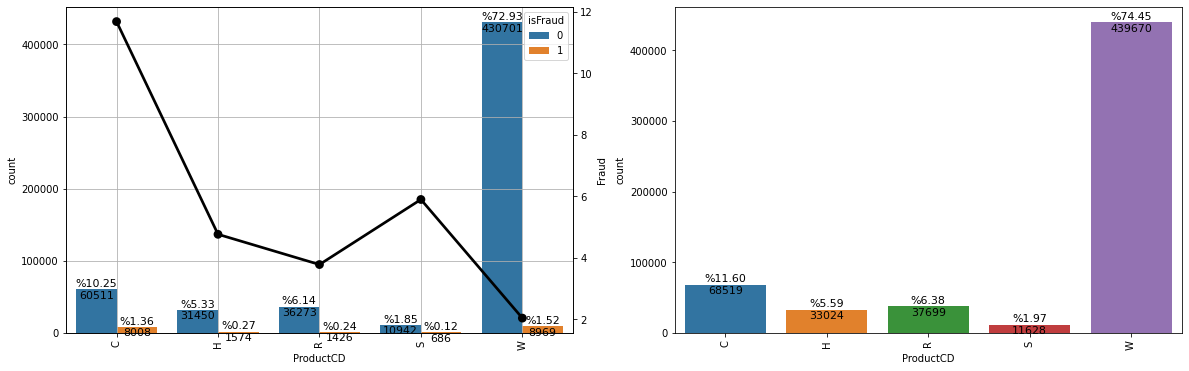

In [187]:
plot_col('ProductCD', df=df)

#### Label Encoders

In [188]:
# column_details(regex='ProductCD', df=df)

In [189]:
# cat_cols= columns
df= label_encoder(cat_cols=columns, df=df)

### DeviceInfo

In [190]:
column_details(regex='DeviceInfo', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceInfo:  object, 1786, %79.91
['0PAJ5' '0PJA2' '0PM92' ... 'vivo' 'xs-Z47b7VqTMxs' nan]



In [191]:
df.DeviceInfo.replace(regex={r'.*SAMSUNG.*': 'samsung',
                        '.*SM.*': 'samsung',
                        '^SC.*': 'samsung',
                        '.*Lenovo.*': 'lenovo',
                        '^V.*': 'lg',
                        '.*LG.*': 'lg',
                        '.*HUAWEI.*':'huawei',
                        '.*Huawei.*':'huawei',
                        '.*Moto.*':'motorola',
                        '.*moto.*':'motorola',
                        '.*HTC.*':'htc',
                        '.*Redmi.*':'redmi',
                        '.*Blade.*':'blade',
                        '.*BLADE.*':'blade',    
                        '.*Nexus.*':'nexus',
                        '.*GT.*':'gt',
                        '.*Pixel.*':'pixel',
                        '.*Hisense.*':'hisense',
                        '.*ALCATEL.*':'alcatel',
                        '.*ASUS.*':'asus',
                        '.*Ilium.*':'ilium',
                        '.*iris.*':'iris',
                        '.*Aquaris.*':'aquaris',
                        '.*Archos.*':'archos',
                        '.*Linux.*':'linux',
                        '.*Android.*':'android',
                        '.*Microsoft.*':'microsoft',
                        '.*MacOS.*':'macOS',
                        '.*Trident.*':'trident',
                        '.*rv.*':'rv',
                        '.*XT.*':'xt',
                        '.*Windows.*':'windows',
                        '.*TA.*':'ta',
                        '.*iOS.*':'ios',
                        '.*verykool.*':'verykool',
                        '.*0PM92.*':'htc',
                        '.*2PS64.*':'htc',
                        '.*HONOR.*':'honor',
                        '.*EGO.*':'other',
                         '^50.*':'alcatel',
                         '^60.*':'alcatel',
                         '^80.*':'alcatel',
                         '^A.*':'alcatel',
                         '^[CEFG].*':'sony',
                         '^SG.*':'sony',
                         '^M4.*':'m4',
                         '.*MOT.*':'morotola',
                         '^Mi.*':'xiaomi',
                         '^MI.*':'xiaomi',
                         '^Z.*':'zte',
                         '^K.*':'android'}, inplace=True)

# df['DeviceInfo'] = simplify_column('DeviceInfo', df=df, threshold=0.0005, value='other')
df.DeviceInfo.value_counts(dropna=False, normalize=True)


NaN                         0.799055
windows                     0.080901
ios                         0.033498
macOS                       0.021291
samsung                     0.020254
                              ...   
U FEEL LITE Build/MRA58K    0.000002
1016S                       0.000002
WAS-LX2J                    0.000002
Robin                       0.000002
Mobiistar_LAI_Yuna_X        0.000002
Name: DeviceInfo, Length: 280, dtype: float64

#### Reduction of diversity in categorical columns

In [192]:
# for col in columns:
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')

#### Plots

In [193]:
# plot_col('DeviceInfo', df=df)

#### Label Encoders

In [194]:
# column_details(regex='DeviceInfo', df=df)

In [195]:
# cat_cols= columns
df= label_encoder(cat_cols=columns, df=df)

### DeviceType

In [196]:
column_details(regex='DeviceType', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

DeviceType:  object, 2, %76.16
['desktop' 'mobile' nan]



#### Reduction of diversity in categorical columns

In [197]:
# for col in columns:
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')

#### Plots

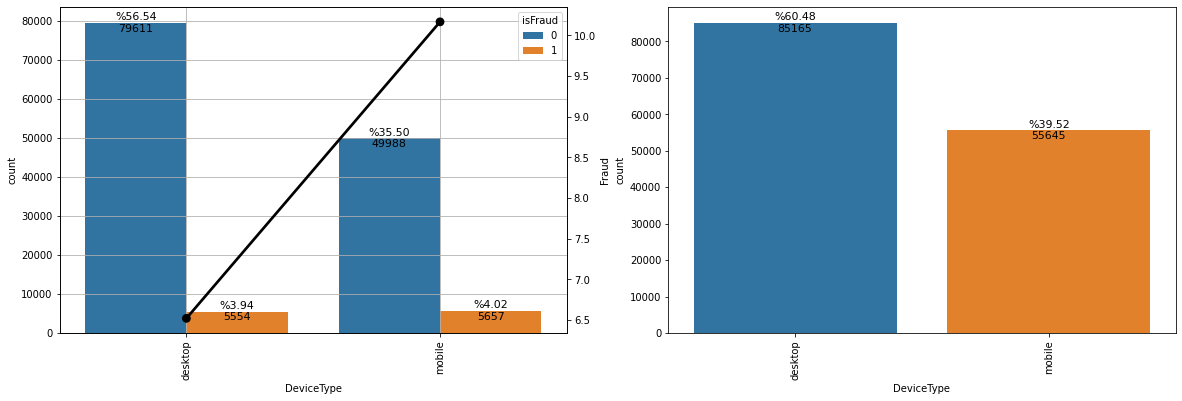

In [198]:
plot_col('DeviceType', df=df)

#### Label Encoders

In [199]:
# column_details(regex='DeviceType', df=df)

In [200]:
# cat_cols= columns
df= label_encoder(cat_cols=columns, df=df)

### R_emaildomain

In [201]:
column_details(regex='R_emaildomain', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

R_emaildomain:  object, 60, %76.75
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'scranton.edu' 'servicios-ta.com' 'suddenlink.net' 'twc.com'
 'verizon.net' 'web.de' 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk'
 'yahoo.com' 'yahoo.com.mx' 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com'
 nan]



#### Feature Engineering

In [202]:
df[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = df['R_emaildomain'].str.split('.', expand=True)

In [203]:
df = df.drop('R_emaildomain', axis=1)

#### Reduction of diversity in categorical columns

In [204]:
# for col in columns:
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')

#### Plots

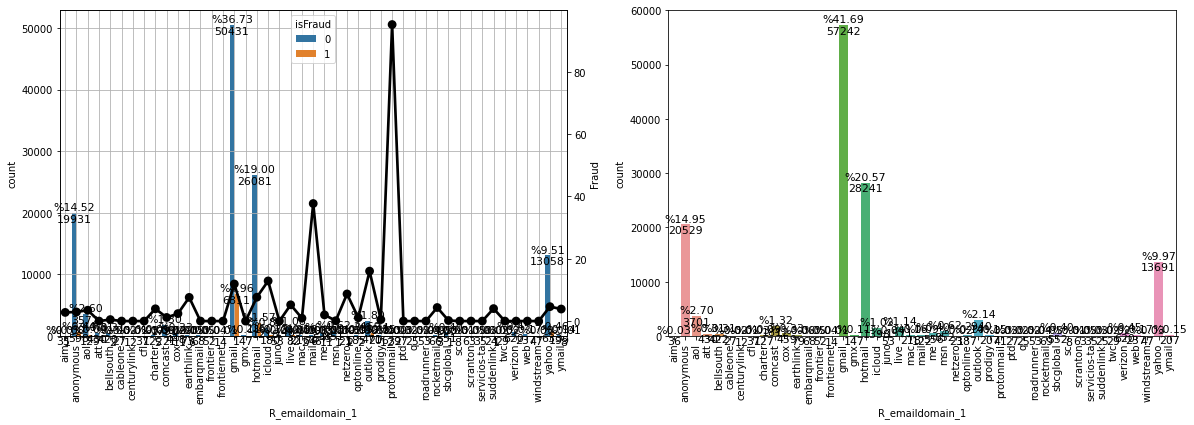

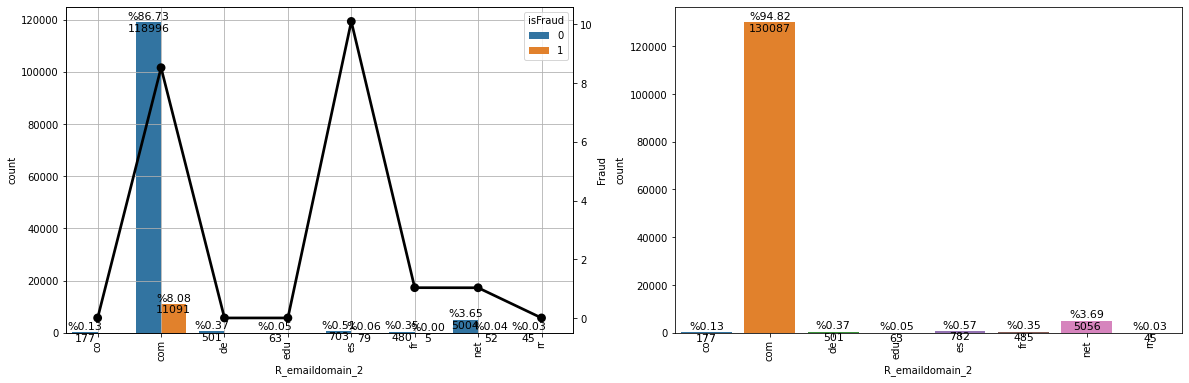

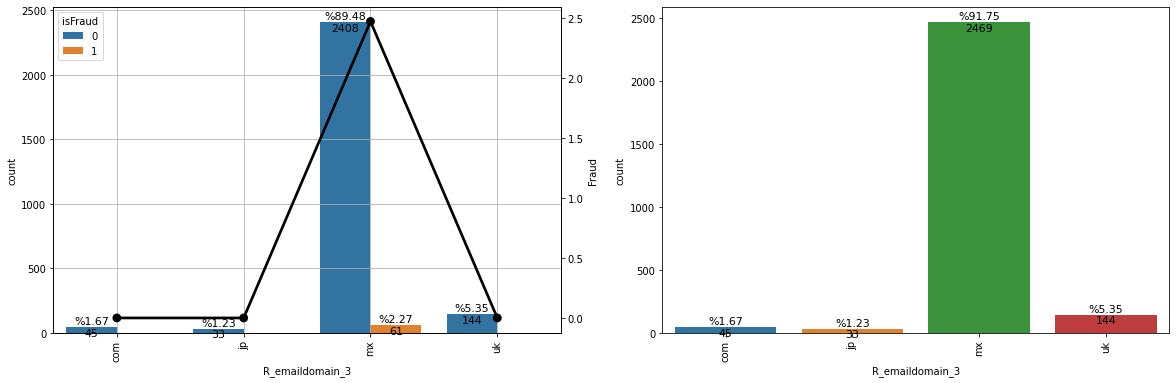

In [205]:
for col in ['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']:
  plot_col(col, df=df)

#### Label Encoders

In [206]:
cat_cols= ['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
df= label_encoder(cat_cols=cat_cols, df=df)

### P_emaildomain

In [207]:
column_details(regex='P_emaildomain', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

P_emaildomain:  object, 59, %15.99
['aim.com' 'anonymous.com' 'aol.com' 'att.net' 'bellsouth.net'
 'cableone.net' 'centurylink.net' 'cfl.rr.com' 'charter.net' 'comcast.net'
 'cox.net' 'earthlink.net' 'embarqmail.com' 'frontier.com'
 'frontiernet.net' 'gmail' 'gmail.com' 'gmx.de' 'hotmail.co.uk'
 'hotmail.com' 'hotmail.de' 'hotmail.es' 'hotmail.fr' 'icloud.com'
 'juno.com' 'live.com' 'live.com.mx' 'live.fr' 'mac.com' 'mail.com'
 'me.com' 'msn.com' 'netzero.com' 'netzero.net' 'optonline.net'
 'outlook.com' 'outlook.es' 'prodigy.net.mx' 'protonmail.com' 'ptd.net'
 'q.com' 'roadrunner.com' 'rocketmail.com' 'sbcglobal.net' 'sc.rr.com'
 'servicios-ta.com' 'suddenlink.net' 'twc.com' 'verizon.net' 'web.de'
 'windstream.net' 'yahoo.co.jp' 'yahoo.co.uk' 'yahoo.com' 'yahoo.com.mx'
 'yahoo.de' 'yahoo.es' 'yahoo.fr' 'ymail.com' nan]



#### Feature Engineering

In [208]:
df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)

In [209]:
df = df.drop('P_emaildomain', axis=1)

#### Reduction of diversity in categorical columns

In [210]:
# for col in columns:
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')

#### Plots

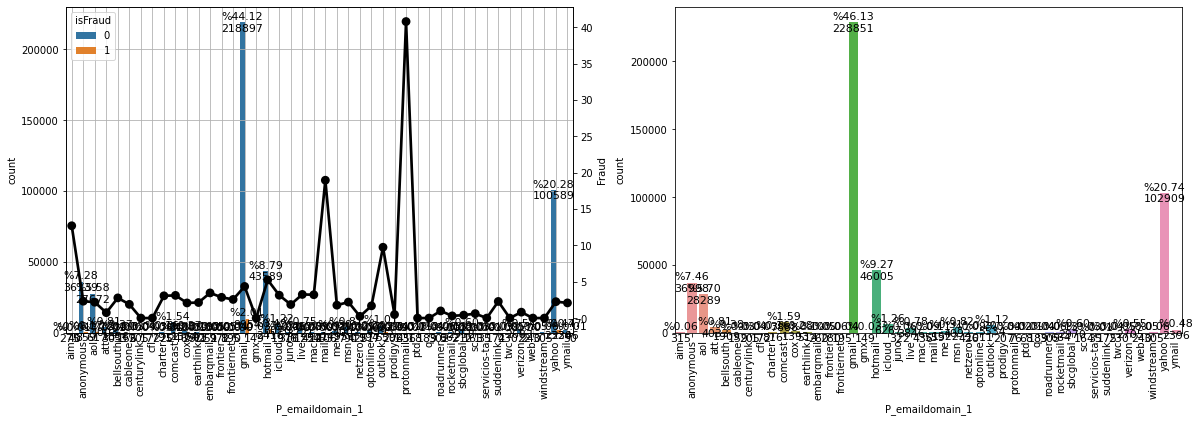

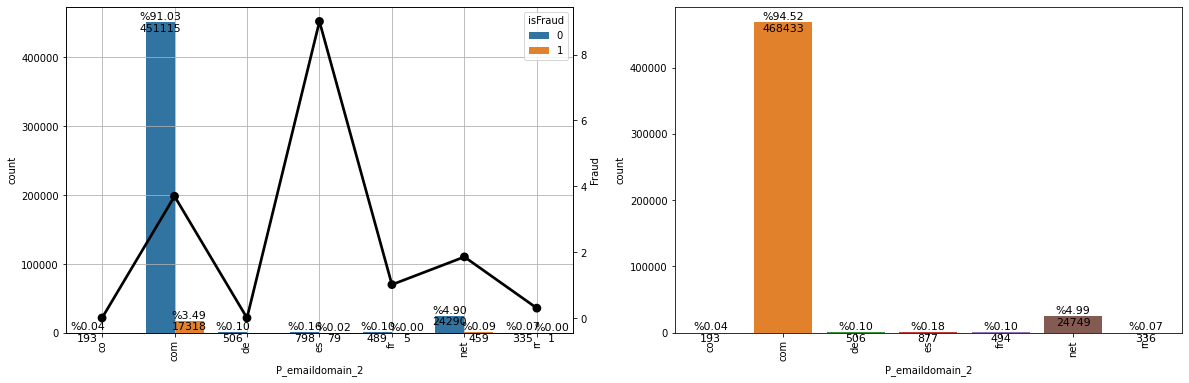

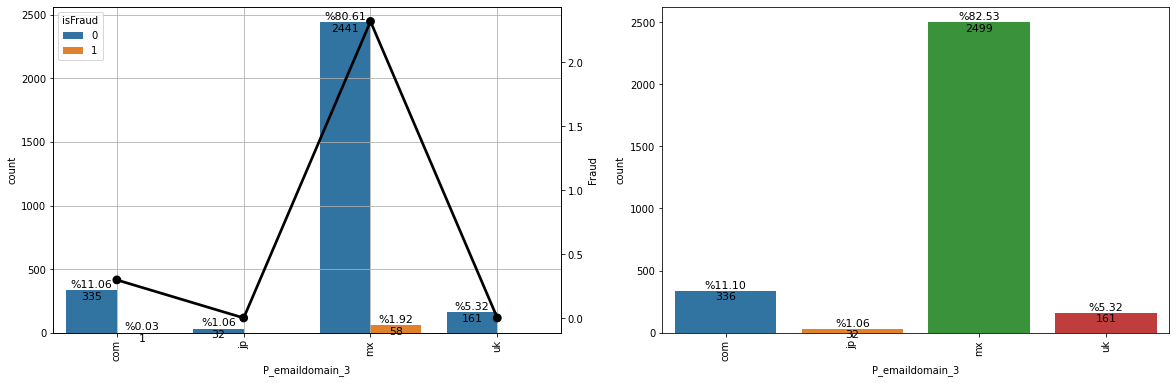

In [211]:
for col in ['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']:
  plot_col(col, df=df)

#### Label Encoders

In [212]:
cat_cols= ['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']
df= label_encoder(cat_cols=cat_cols, df=df)

### Transaction_hour

In [213]:
column_details(regex='Transaction_hour', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

Transaction_hour:  float64, 24, %0.0
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23.]



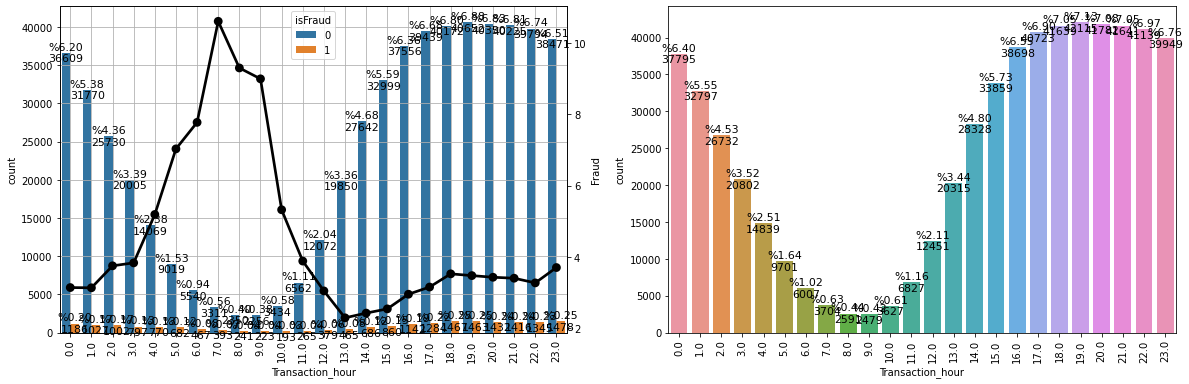

In [214]:
plot_col('Transaction_hour', df=df)

### Transaction_day_of_week

In [215]:
column_details(regex='Transaction_day_of_week', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

Transaction_day_of_week:  float64, 7, %0.0
[0. 1. 2. 3. 4. 5. 6.]



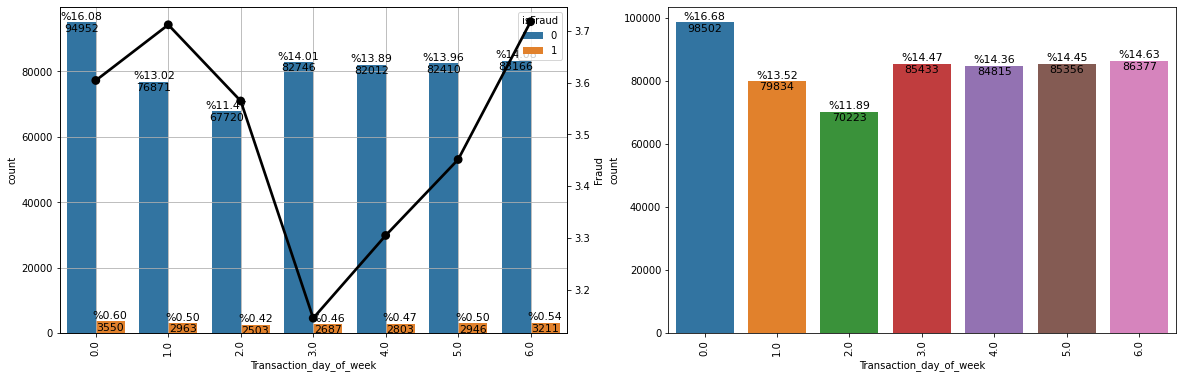

In [216]:
plot_col('Transaction_day_of_week', df=df)

### TransactionDT

In [217]:
df['TransactionDT']= data.TransactionDT.copy()

In [218]:
column_details(regex='TransactionDT', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

TransactionDT:  int64, 573349, %0.0
[   86400    86401    86469 ... 15811079 15811088 15811131]



In [219]:
(df['TransactionDT']//(3600*24)).describe()

count    590540.000000
mean         84.729199
std          53.437277
min           1.000000
25%          35.000000
50%          84.000000
75%         130.000000
max         182.000000
Name: TransactionDT, dtype: float64

In [220]:
df[df.isFraud==1]['TransactionAmt'].median(), \
df[df.isFraud==0]['TransactionAmt'].median()

(75.0, 68.5)

In [221]:
# plt.figure(figsize=(15,8))
# plt.suptitle('Time of transaction vs Amount by isFraud')
# fraud_mean, nonfraud_mean = df[df.isFraud==1]['TransactionAmt'].mean(), df[df.isFraud==0]['TransactionAmt'].mean()
# sns.scatterplot(x=df['TransactionDT']//(3600*24), y=df['TransactionAmt'], data=df, hue='isFraud', size="isFraud", sizes=(200, 20))
# plt.axhline(y=fraud_mean ,color='red',label=f'fraud mean:{round(fraud_mean,2)}')
# plt.axhline(y=nonfraud_mean, color='green',label=f'non-froud mean:{round(nonfraud_mean,2)}')
# plt.legend()

# plt.yscale('log')
# plt.show()

In [222]:
df = df.drop('TransactionDT',axis=1)

### TransactionAmt

In [223]:
column_details(regex='TransactionAmt', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

TransactionAmt:  float32, 20902, %0.0
[2.510000e-01 2.720000e-01 2.920000e-01 ... 6.085230e+03 6.450970e+03
 3.193739e+04]



In [224]:
df.TransactionAmt.describe()

count    590540.000000
mean        134.849213
std         239.162720
min           0.251000
25%          43.320999
50%          68.769001
75%         125.000000
max       31937.390625
Name: TransactionAmt, dtype: float64

#### Handling Outliers

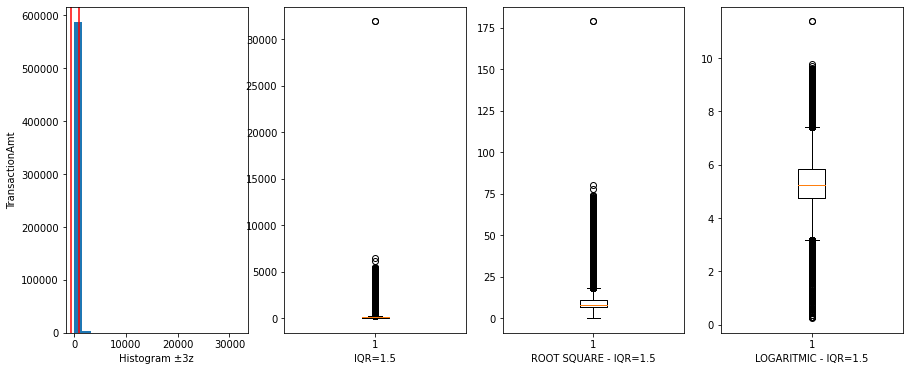

In [225]:
col_plot(df, 'TransactionAmt')

In [226]:
# plot_winsorize(df,'TransactionAmt')

In [227]:
# df.TransactionAmt = pd.Series( winsorize(np.sqrt(df.TransactionAmt), limits=(0, 0.1)))
df.TransactionAmt.describe()

count    590540.000000
mean        134.849213
std         239.162720
min           0.251000
25%          43.320999
50%          68.769001
75%         125.000000
max       31937.390625
Name: TransactionAmt, dtype: float64

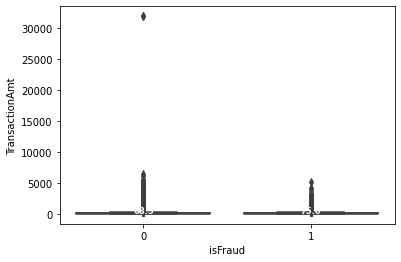

In [228]:
ax = sns.boxplot(x='isFraud',y='TransactionAmt', data=df)
box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='TransactionAmt');

### addr1

In [229]:
column_details(regex='addr', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

addr1:  float16, 332, %11.13
[100. 101. 102. 104. 105. 106. 110. 111. 112. 113. 117. 119. 120. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 137. 139.
 141. 142. 143. 144. 145. 146. 148. 151. 152. 153. 154. 155. 156. 157.
 158. 159. 160. 161. 162. 163. 164. 166. 167. 168. 170. 171. 172. 174.
 177. 178. 180. 181. 182. 183. 184. 185. 187. 189. 190. 191. 193. 194.
 195. 196. 198. 199. 200. 201. 202. 203. 204. 205. 206. 208. 210. 211.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 223. 224. 225. 226. 227.
 231. 232. 233. 234. 235. 236. 237. 238. 239. 241. 242. 243. 244. 245.
 247. 248. 249. 250. 251. 252. 253. 254. 255. 257. 258. 259. 260. 261.
 262. 264. 265. 268. 269. 270. 272. 274. 275. 276. 277. 278. 279. 280.
 282. 283. 284. 286. 290. 292. 294. 295. 296. 297. 298. 299. 300. 301.
 302. 303. 304. 305. 306. 307. 308. 309. 310. 312. 313. 314. 315. 316.
 318. 321. 322. 323. 324. 325. 326. 327. 328. 329. 3

In [230]:
df.addr1.describe()

count    524834.0
mean          NaN
std           NaN
min         100.0
25%         204.0
50%         299.0
75%         330.0
max         540.0
Name: addr1, dtype: float64

#### Handling Outliers

In [231]:
# col_plot(df, 'addr1')

In [232]:
# plot_winsorize(df,'addr1')

In [233]:
# df.TransactionAmt = pd.Series( winsorize(np.sqrt(df.TransactionAmt), limits=(0, 0.1)))
df.addr1.describe()

count    524834.0
mean          NaN
std           NaN
min         100.0
25%         204.0
50%         299.0
75%         330.0
max         540.0
Name: addr1, dtype: float64

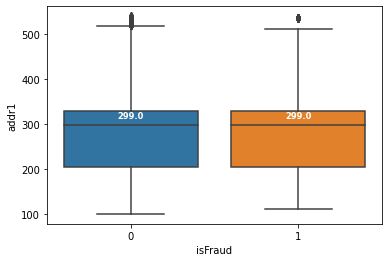

In [234]:
ax = sns.boxplot(x='isFraud',y='addr1', data=df)
box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='addr1');

### M1-9

In [235]:
column_details(regex='M\d*', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

M2:  object, 2, %45.91
['F' 'T' nan]

M3:  object, 2, %45.91
['F' 'T' nan]

M4:  object, 3, %47.66
['M0' 'M1' 'M2' nan]

M5:  object, 2, %59.35
['F' 'T' nan]

M6:  object, 2, %28.68
['F' 'T' nan]

M7:  object, 2, %58.64
['F' 'T' nan]

M8:  object, 2, %58.63
['F' 'T' nan]

M9:  object, 2, %58.63
['F' 'T' nan]



#### Multicolliniarity

In [236]:
# msno.heatmap(df[columns], figsize=(10, 5), fontsize=10);

In [237]:
pd.Series([cramers_v(df.M3,df[col]) for col in columns], index=columns).sort_values(ascending=False)

M3    0.999991
M2    0.665148
M9    0.232538
M8    0.098631
M7    0.060395
M6    0.021573
M4    0.015603
M5    0.011611
dtype: float64

In [238]:
# cramers_v(df.M2,df.M3)

> We determined the correlation threshold upper than 0.8. Therefore, we don't drop M3.

#### Handling Outliers

> There is no outlier in M columns

#### Plots

In [239]:
# for col in columns:
#   plot_col(col, df=df, figsize=(12,5))

In [240]:
# plot_cols(regex='M\d*', figsize=(7, 25), target='isFraud')

In [241]:
# hist_countplot(regex='M\d*', figsize=(20, 10), nrow=2, ncolumn = 4)

In [242]:
# box_countplot(regex='M\d*', figsize=(20, 10), nrow=4, ncolumn = 2)

#### Label Encoders

In [243]:
df= label_encoder(cat_cols=columns, df=df)

### D1-15

In [244]:
column_details(regex='^D\d', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

D1:  float16, 641, %0.21
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 

#### Multicolliniarity

In [245]:
# msno.heatmap(df[columns], figsize=(10, 5), fontsize=10);

In [246]:
# plt.figure(figsize=(15,10))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [247]:
# corrank(df[columns], 0.8)

In [248]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'D12', 'D2', 'D6'}

In [249]:
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [250]:
columns=[col for col in df.columns if re.search('^D\d', col)]

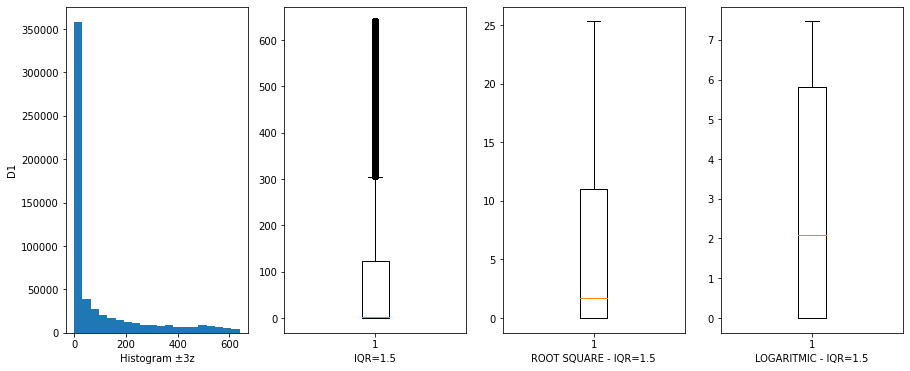

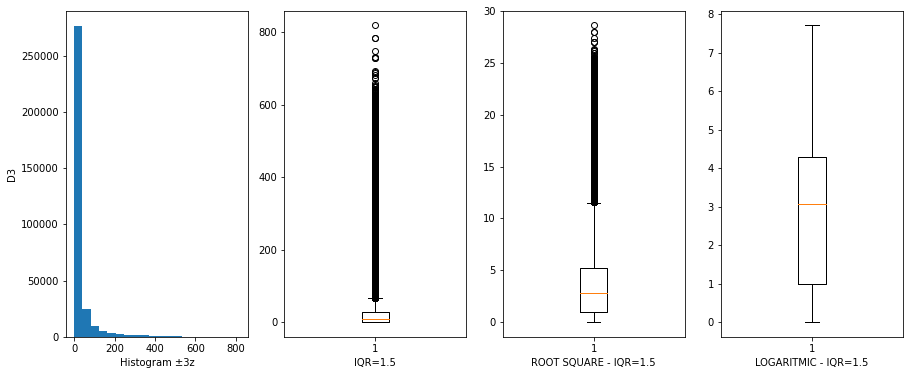

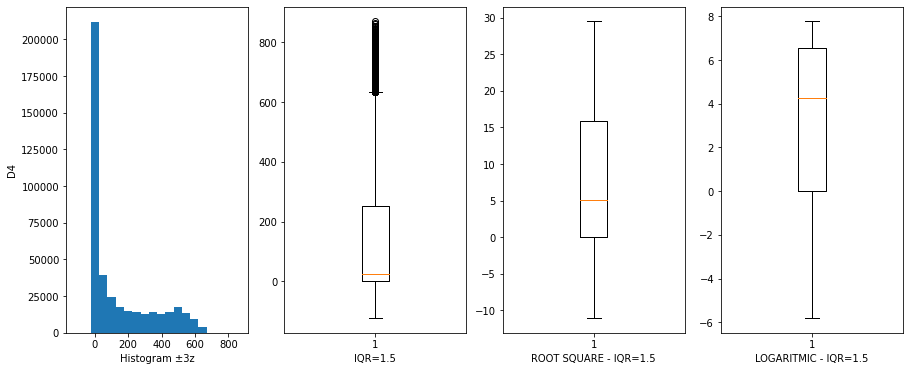

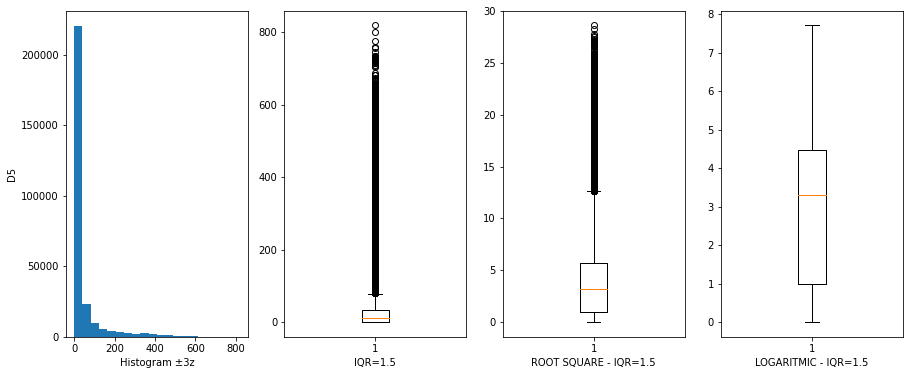

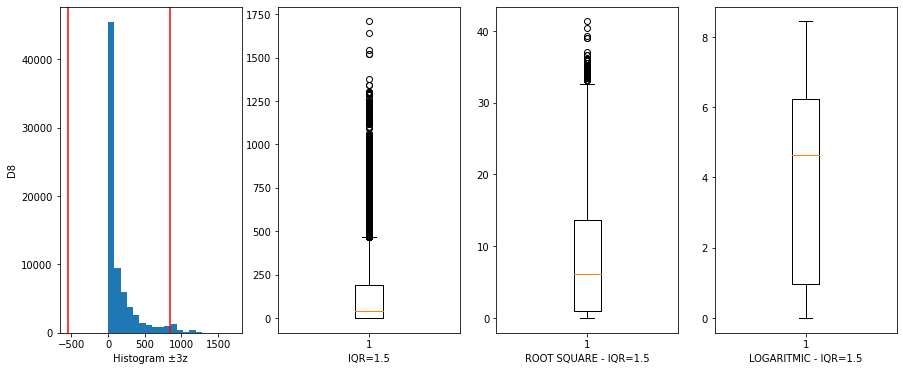

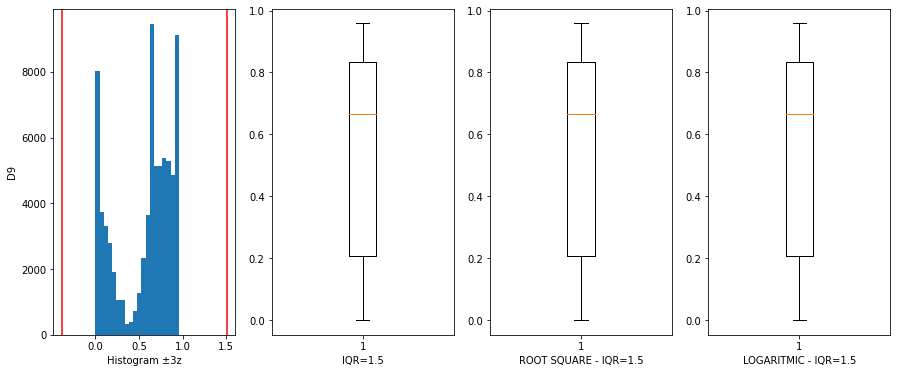

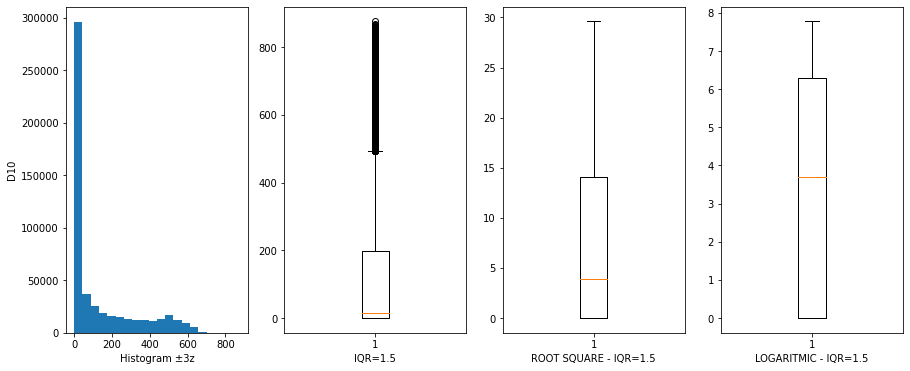

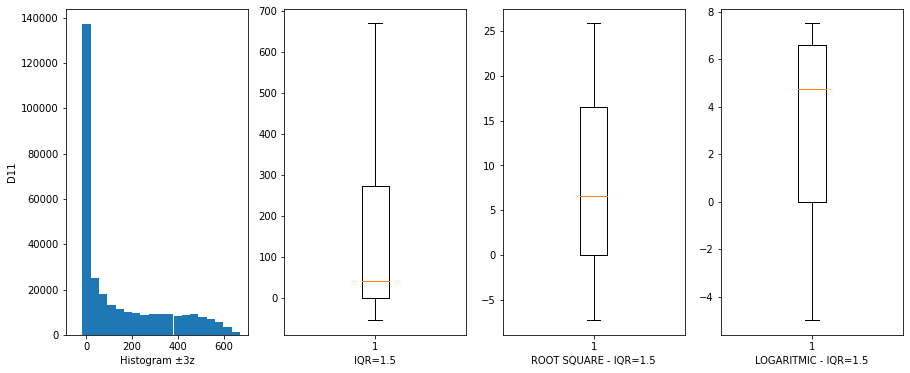

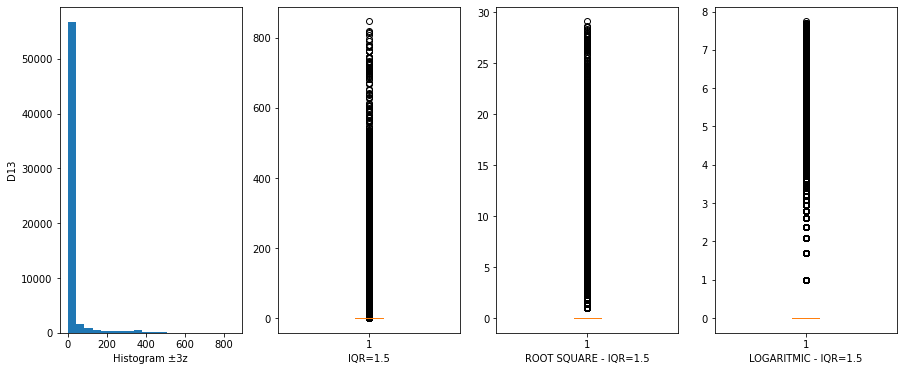

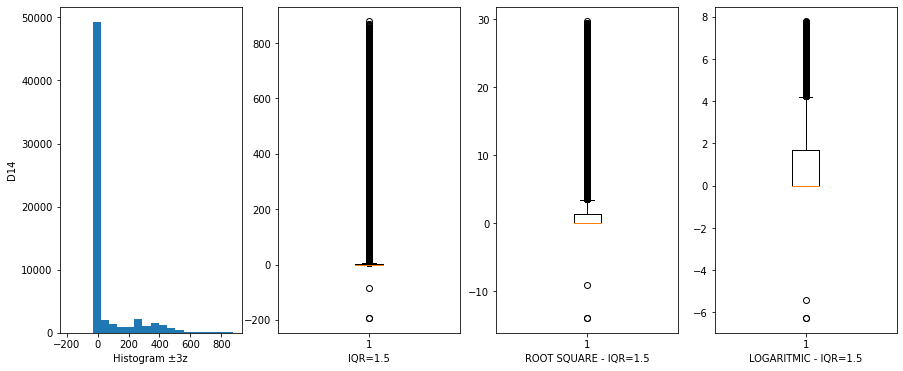

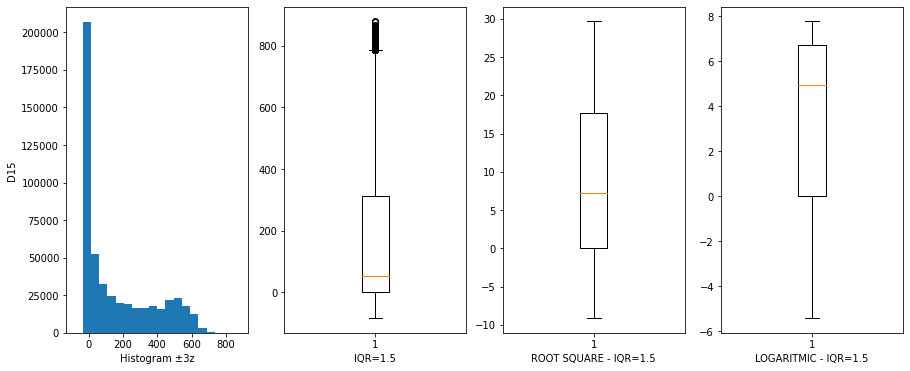

In [251]:
for col in columns:
  col_plot(df[col].dropna().to_frame(), col)

In [252]:
# for col in columns:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [253]:
# for col in columns[4:]:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [254]:
# f_log=lambda x:(np.log(x)+1 if x>1 else -np.log(-x)-1 if x<-1 else x)
# log_cols = ['D1','D3','D5','D8','D10','D15']
# for col in log_cols:
#   df[col] = df[col].apply(f_log)

In [255]:
# f_sqrt=lambda x:(np.sqrt(x) if x>1 else -np.sqrt(-x) if x<-1 else x)
# df.D4 = df.D4.apply(f_sqrt)

In [256]:
# df.D14 = df.D14.apply(lambda x: 1 if x>0 else x)
# df.D13 = df.D14.apply(lambda x: 1 if x>0 else x)

#### Plots

In [257]:
# plot_col('D14', df=df)

In [258]:
# plot_cols(regex='^D\d', figsize=(30,50), target='isFraud')

In [259]:
# hist_countplot(regex='^D\d', figsize=(20, 15), nrow=3, ncolumn = 5)

In [260]:
# box_countplot(regex='^D\d', figsize=(15, 15), nrow=4, ncolumn = 3, df=df)

### C1-14

In [261]:
column_details(regex='^C\d', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

C1:  int16, 1657, %0.0
[   0    1    2 ... 4682 4684 4685]

C2:  int16, 1216, %0.0
[   0    1    2 ... 5625 5690 5691]

C4:  int16, 1260, %0.0
[   0    1    2 ... 2251 2252 2253]

C5:  int16, 319, %0.0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 

#### Multicolliarity

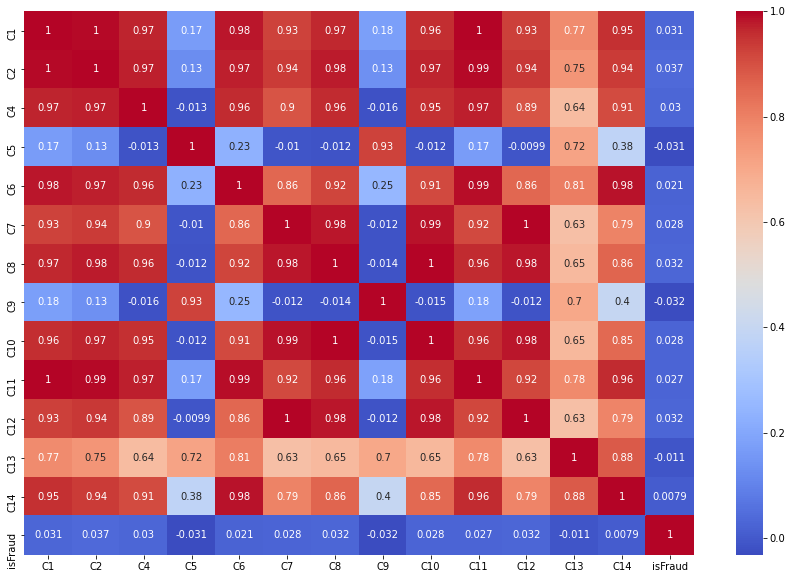

In [262]:
plt.figure(figsize=(15,10))
sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [263]:
# corrank(df[columns], 0.8)

In [264]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

{'C10', 'C11', 'C12', 'C13', 'C14', 'C2', 'C4', 'C6', 'C7', 'C8', 'C9'}

In [265]:
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [266]:
columns=[col for col in df.columns if re.search('^C\d', col)]
columns

['C1', 'C5']

In [267]:
# for col in columns:
#   col_plot(df[col].dropna().to_frame(),col)

In [268]:
# for col in columns:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [269]:
# for col in columns:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [270]:
# for col in columns:
#   df[col] = pd.Series( winsorize(df[col], limits=(0, 0.1)))

In [271]:
# ax = sns.boxplot(x='isFraud',y='C1', data=df)
# box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='C1');

In [272]:
# box_countplot(regex='^C\d', figsize=(10, 5), nrow=1, ncolumn = 2, df=df)

#### Plots

In [273]:
# for col in columns:
#   plot_col(col, df=df, figsize=(12,5))

In [274]:
# plot_cols(regex='^C\d', figsize=(20, 1), target='isFraud')

In [275]:
# hist_countplot(regex='^C\d', figsize=(20, 15), nrow=3, ncolumn = 5)

In [276]:
# box_countplot(regex='^C\d', figsize=(20,15), nrow=3, ncolumn = 5)

#### Label Encoders

In [277]:
# df= label_encoder(cat_cols=columns, df=df)

### dist1-2

In [278]:
column_details(regex='^dist', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

dist1:  float32, 2651, %59.65
[0.0000e+00 1.0000e+00 2.0000e+00 ... 8.0810e+03 1.0286e+04        nan]



In [279]:
df.dist1.describe()

count    238269.000000
mean        118.489471
std         371.947357
min           0.000000
25%           3.000000
50%           8.000000
75%          24.000000
max       10286.000000
Name: dist1, dtype: float64

#### Multicolliarity

In [280]:
# plt.figure(figsize=(4,4))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [281]:
# corrank(df[columns], 0.8)

In [282]:
# drop_col = remove_collinear_features(df[columns],0.80)
# drop_col

In [283]:
# df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [284]:
columns=[col for col in df.columns if re.search('^dist', col)]

In [285]:
# for col in columns:
#   col_plot(df[col].dropna().to_frame(),col)

In [286]:
# for col in columns:
#   plot_winsorize(df[col].dropna().to_frame(),col)

In [287]:
# for col in columns:
#   plot_log_winsorize(df[col].dropna().to_frame(),col)

In [288]:
# df.dist1 = pd.Series( winsorize(df.dist1.apply(f_log), limits=(0, 0.1)))
df.dist1.describe()

count    238269.000000
mean        118.489471
std         371.947357
min           0.000000
25%           3.000000
50%           8.000000
75%          24.000000
max       10286.000000
Name: dist1, dtype: float64

In [289]:
# ax = sns.boxplot(x='isFraud',y='dist1', data=df)
# box_labels(ax=ax, df=df.sort_values('isFraud'),col1='isFraud',col2='dist1');

#### Plots

In [290]:
# plot_col('dist1')

In [291]:
# plot_cols(regex='^dist\d', figsize=(20, 8), target='isFraud')

In [292]:
# hist_countplot(regex='^dist\d', figsize=(20, 8), nrow=1, ncolumn = 1)

In [293]:
# box_countplot(regex='^dist\d', figsize=(20,8), nrow=1, ncolumn = 1)

### card1-6

In [294]:
column_details(regex='^card', df=df)

Unique Values of the Features:
feature: DTYPE, NUNIQUE, NULL_RATE

card1:  int16, 13553, %0.0
[ 1000  1001  1004 ... 18393 18395 18396]

card2:  float16, 500, %1.51
[100. 101. 102. 103. 104. 105. 106. 108. 109. 110. 111. 112. 113. 114.
 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126. 127. 128.
 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142.
 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154. 155. 156.
 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168. 169. 170.
 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182. 183. 184.
 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196. 197. 198.
 199. 200. 201. 202. 203. 204. 205. 206. 207. 208. 209. 210. 211. 212.
 213. 214. 215. 216. 217. 218. 219. 220. 221. 222. 223. 224. 225. 226.
 227. 228. 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240.
 241. 242. 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254.
 255. 256. 257. 258. 259. 260. 261. 262. 263. 264. 265

#### Reduction of diversity in categorical columns

In [295]:
# for col in ['card3', 'card5']:
#   df[col] = simplify_column(col, df=df, threshold=0.0005, value='mode')
#   plot_col(col, df=df, figsize=(12,5))

#### Multicolliarity

In [296]:
# plt.figure(figsize=(8,5))
# sns.heatmap(df[columns+['isFraud']].corr(),annot=True, cmap="coolwarm");

In [297]:
# corrank(df[columns], 0.8)

In [298]:
drop_col = remove_collinear_features(df[columns],0.80)
drop_col

set()

In [299]:
df = df.drop(drop_col, axis=1)

#### Handling Outliers

In [300]:
columns=[col for col in df.columns if re.search('^card', col)]

In [301]:
# for col in ['card1','card2']:
#   col_plot(df[col].dropna().to_frame(),col)

In [302]:
# for col in columns:
#   if df[col].dtype!='O':
#     plot_winsorize(df[col].dropna().to_frame(),col)

> card3-4-5-6 columns are categoric, The rest dont have any outlier problem.

#### Plots

In [303]:
# for col in ['card3', 'card4', 'card5', 'card6']:
#   plot_col(col, df=df, figsize=(20,5))

In [304]:
# plot_cols(regex='^card*', figsize=(30, 15), target='isFraud')

In [305]:
# hist_countplot(regex='^card*', figsize=(30, 15), nrow=2, ncolumn = 3)

In [306]:
# box_countplot(regex='^card*', figsize=(30, 15), nrow=2, ncolumn = 3)

#### Label Encoders

In [307]:
# cat_cols = ['card3', 'card4', 'card5', 'card6']
cat_cols = ['card4', 'card6']
df= label_encoder(cat_cols=cat_cols, df=df)

### Last Review

In [308]:
# Columns having one unique value
one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
one_value_cols

[]

In [309]:
len(one_value_cols)

0

### Export Data

In [310]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/Fraud Detection/input/after_eda_phase2.csv')

In [311]:
df.head()

,isFraud,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,dist1,C1,C5,D1,D3,D4,D5,D8,D9,D10,D11,D13,D14,D15,M2,M3,M4,M5,M6,M7,M8,M9,V2,V3,V4,V6,V7,V8,V10,V12,...,V283,V288,V291,V313,V314,V325,id_01,id_02,id_03,id_05,id_06,id_09,id_10,id_11,id_12,id_13,id_14,id_17,id_19,id_20,id_28,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Transaction_hour,Transaction_day_of_week,R_emaildomain_1,R_emaildomain_2,R_emaildomain_3,P_emaildomain_1,P_emaildomain_2,P_emaildomain_3
0,0,68.5,4,13926,NaN,150.0,1,142.0,1,315.0,19.0,1,0,14.0,13.0,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,0.0,1,1,2,0,1,2,2,2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,54,25,104,522,394,2,5,23,4,256,4,2,2,2,2,2,262,0.0,0.0,25,7,4,25,6,4
1,0,29.0,4,2755,404.0,150.0,2,102.0,1,325.0,NaN,1,0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,2,2,0,1,1,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,54,25,104,522,394,2,5,23,4,256,4,2,2,2,2,2,262,0.0,0.0,25,7,4,15,2,0
2,0,59.0,4,4663,490.0,150.0,4,166.0,2,330.0,287.0,1,0,0.0,NaN,0.0,NaN,NaN,NaN,0.0,315.0,NaN,NaN,315.0,1,1,0,0,0,0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,54,25,104,522,394,2,5,23,4,256,4,2,2,2,2,2,262,0.0,0.0,25,7,4,28,2,0
3,0,50.0,4,18132,567.0,150.0,2,117.0,2,476.0,NaN,2,0,112.0,0.0,94.0,0.0,NaN,NaN,84.0,NaN,NaN,NaN,111.0,2,2,0,1,0,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,54,25,104,522,394,2,5,23,4,256,4,2,2,2,2,2,262,0.0,0.0,25,7,4,43,2,0
4,0,50.0,1,4497,514.0,150.0,2,102.0,1,420.0,NaN,1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,3,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,100.0,1,54,7,59,400,32,1,0,29,3,121,3,1,0,1,1,1,269,0.0,0.0,25,7,4,15,2,0


### LGB

In [330]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# for modeling 
import sklearn
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# to avoid warnings
import warnings
warnings.filterwarnings('ignore')
warnings.warn("this will not show")



warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [313]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    random_state =42)

In [314]:
# LGBMClassifier with GPU

# clf = lgb.LGBMClassifier(
#           max_bin = 63,
#           num_leaves = 255,
#           num_iterations = 500,
#           learning_rate = 0.01,
#           tree_learner = 'serial',
#           task = 'train',
#           is_training_metric = False,
#           min_data_in_leaf = 1,
#           min_sum_hessian_in_leaf = 100,
#           sparse_threshold=1.0,
#           # device = 'gpu',
#           num_thread = -1,
#           save_binary= True,
#           seed= 42,
#           feature_fraction_seed = 42,
#           bagging_seed = 42,
#           drop_seed = 42,
#           data_random_seed = 42,
#           objective = 'binary',
#           boosting_type = 'gbdt',
#           verbose = 1,
#           metric = 'auc',
#           is_unbalance = True,
#           boost_from_average = False,
# )

clf = lgb.LGBMClassifier(
          num_leaves = 256,
          min_child_samples = 79,
          objective = 'binary',
          max_depth = 13,
          learning_rate = 0.03,
          boosting_type = "gbdt",
          subsample_freq = 3,
          subsample = 0.9,
          bagging_seed = 11,
          metric = 'auc',
          verbosity = -1,
          reg_alpha = 0.3,
          reg_lambda = 0.3,
          colsample_bytree = 0.9,
          is_unbalance = True,
)



In [315]:
%time clf.fit(X_train, y_train)

CPU times: user 2min 13s, sys: 1.12 s, total: 2min 14s
Wall time: 1min 9s


LGBMClassifier(bagging_seed=11, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9, importance_type='split', is_unbalance=True,
               learning_rate=0.03, max_depth=13, metric='auc',
               min_child_samples=79, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=256, objective='binary',
               random_state=None, reg_alpha=0.3, reg_lambda=0.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=3,
               verbosity=-1)

In [316]:
gc.collect()

25866

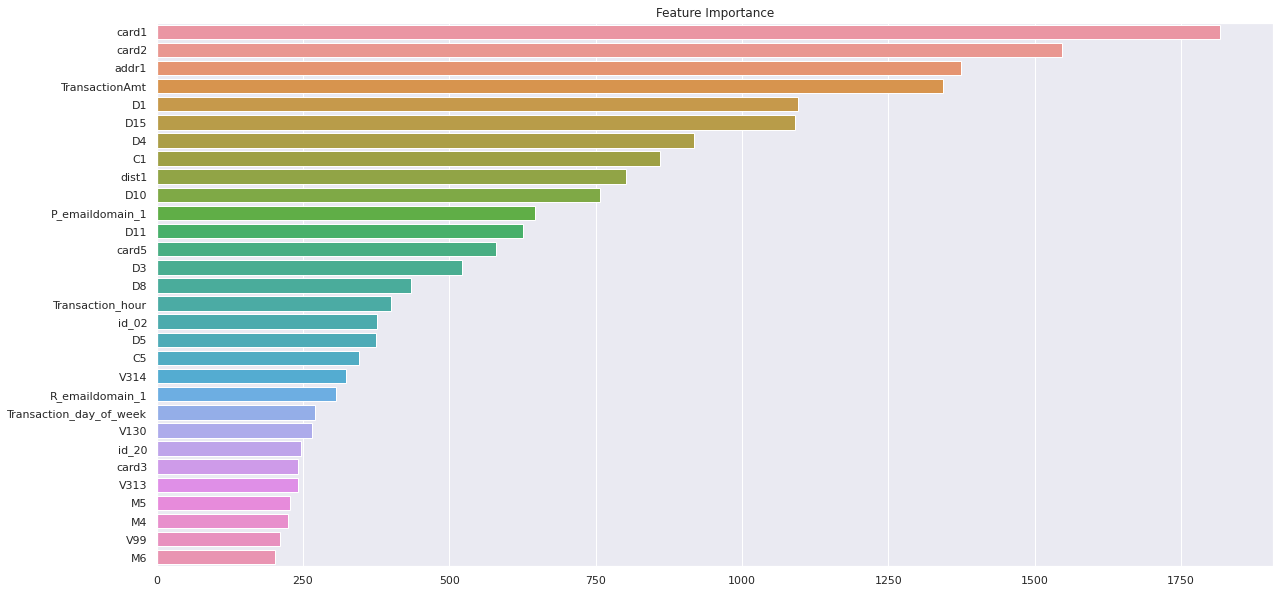

In [317]:
plot_feature_importances(clf, 30)

In [318]:
y_pred = clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.99      0.92      0.96    142469
           1       0.27      0.79      0.40      5166

    accuracy                           0.92    147635
   macro avg       0.63      0.86      0.68    147635
weighted avg       0.97      0.92      0.94    147635



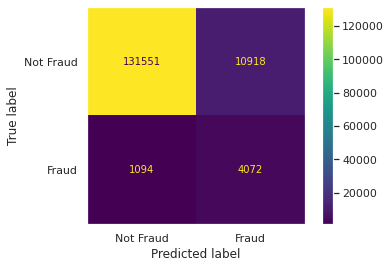

In [319]:
plot_confusion_matrix(clf, X_test, y_test, values_format = '', 
                      display_labels=['Not Fraud', 'Fraud'])
plt.grid(None)
print(classification_report(y_test, y_pred, zero_division=0))

In [347]:
# y_train_pred = clf.predict(X_train)
# plot_confusion_matrix(clf, X_train, y_train, values_format = '', 
#                       display_labels=['Not Fraud', 'Fraud'])
# plt.grid(None)
# print(classification_report(y_train, y_train_pred, zero_division=0))

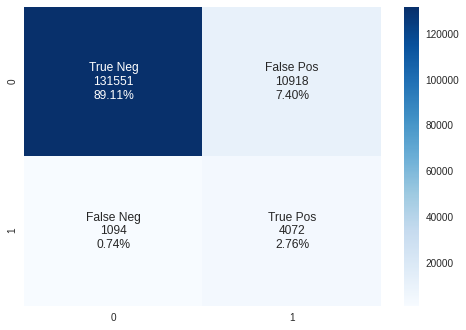

In [344]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues');

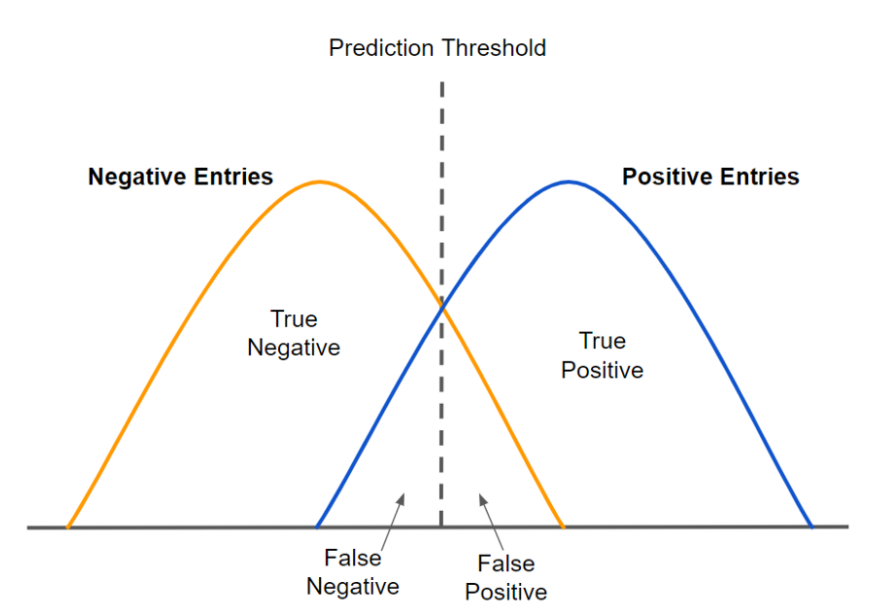

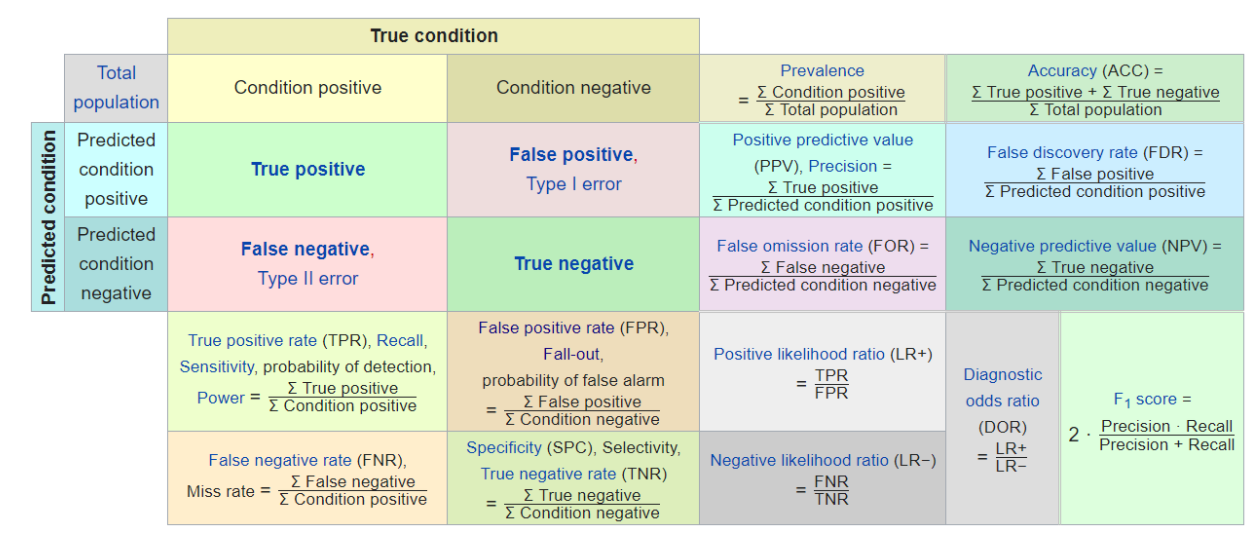

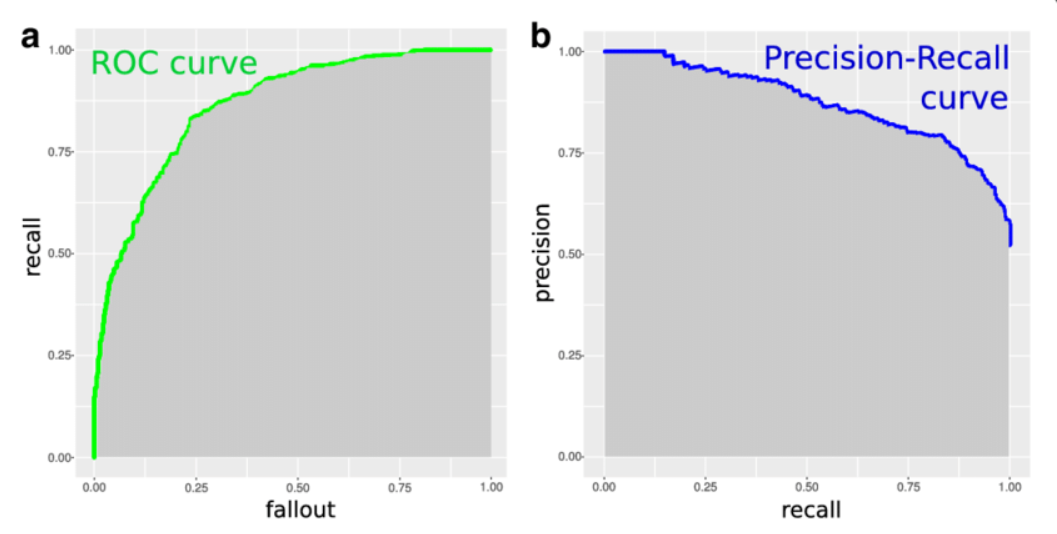

<Figure size 720x720 with 0 Axes>

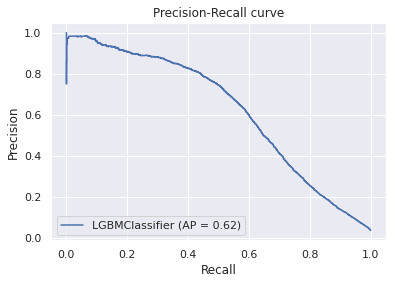

In [321]:
from sklearn.metrics import plot_precision_recall_curve

plt.figure(figsize=(10,10))
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve');

In [350]:
print('Test ROC AUC score:', roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))
print('Train ROC AUC score:', roc_auc_score(y_train, clf.predict_proba(X_train)[:, 1]))

Test ROC AUC score: 0.9761730283782662
Train ROC AUC score: 0.9121297894415212


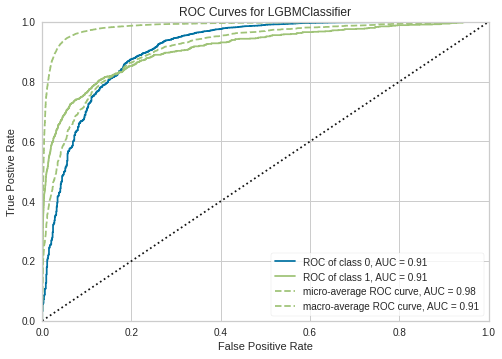

In [348]:
from yellowbrick.classifier import ROCAUC, roc_auc
clf = lgb.LGBMClassifier(
          num_leaves = 256,
          min_child_samples = 79,
          objective = 'binary',
          max_depth = 13,
          learning_rate = 0.03,
          boosting_type = "gbdt",
          subsample_freq = 3,
          subsample = 0.9,
          bagging_seed = 11,
          metric = 'auc',
          verbosity = -1,
          reg_alpha = 0.3,
          reg_lambda = 0.3,
          colsample_bytree = 0.9,
          is_unbalance = True,
)

roc_auc(clf, X_test, y_test) 

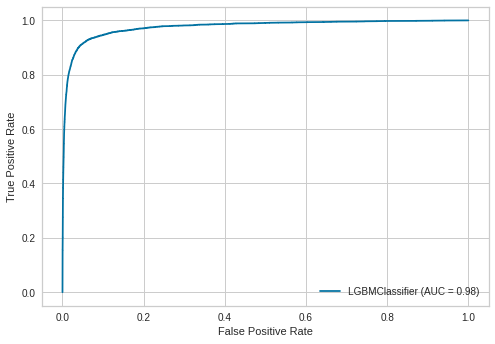

In [349]:
# from sklearn.metrics import plot_roc_curve
plot_roc_curve(clf, X_test, y_test)